In [2]:
import binance
import pandas as pd
from ipywidgets import widgets
import seaborn as sns
import datetime
from matplotlib import pyplot as plt
import time
import datetime
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
import random
import binance
import pandas as pd
from ipywidgets import widgets
import seaborn as sns
import datetime
from matplotlib import pyplot as plt
import time
import datetime
import os
import requests

X_columns = ["gap", "overall_gap", "where_in_gap", "numTrades"] # columns we will keep for 1st preprocessing steps
#X_columns_final = ["gap", "overall_gap", "where_in_gap", "numTrades","buyer_is_maker"]# columns we will keep for last preprocessing steps (after trades have been added)
#X_columns_final = ["ma20","ma100","ma500","ma1000","ma2000","cons_mvt", "tot_mvt","gap_to_lol100", "gap_to_hol100","ma500_trend","numTrades","buyer_is_maker","cons_mvt","tot_mvt","close-ma20","close-ma100", "close-ma500", "close-ma1000", "close-ma2000","ma20-ma100", "ma20-ma500", "ma20-ma1000", "ma20-ma2000" , "ma100-ma500" , "ma100-ma1000" , "ma100-ma2000" , "ma500-ma1000" , "ma500-ma2000" , "ma1000-ma2000", "gap", "ma20_gap", "ma100_gap", "ma500_gap", "ma1000_gap", "ma2000_gap"]
X_columns_final = ["gap_to_lol100", "gap_to_hol100","ma500_trend","numTrades","buyer_is_maker","cons_mvt","tot_mvt","close-ma20","close-ma100", "close-ma500", "close-ma1000", "close-ma2000","ma20-ma100", "ma20-ma500", "ma20-ma1000", "ma20-ma2000" , "ma100-ma500" , "ma100-ma1000" , "ma100-ma2000" , "ma500-ma1000" , "ma500-ma2000" , "ma1000-ma2000","gap", "ma20_gap", "ma100_gap", "ma500_gap", "ma1000_gap", "ma2000_gap"]
# columns we will keep for last preprocessing steps (after trades have been added)
y_columns = ['is_l100','is_h100'] # our Y columns
#time_step= 100 # how many time units used to explain each output
time_step= 20 # how many time units used to explain each output

check_steps = [10,100,1000,10000,50000,100000,150000] # used as monitoring steps for progress during long calculation processes

start_point = '1544844000000' # timestamp (in ms) to start from: Dec 15th 2018, when we started data collection from
current_point = 1556184840000 # current time: Apr 25th 11:34 am, when I started traininf the LSTM network
test_point = 1559477896000  # June 2nd, when i'm trying to run the algo on real fresh data

low_limit = .0001 # values to ignore in your balance (Not Used yet, will be for further integration with Binance Portofolio)

btcusd = 'BTCUSDT'# the exchange we're using as BTC valuation in USD


# depth of history for min, hrs, day, month when we call Binance APIs
depth_min = '1000'
depth_hrs = '120'
depth_day = '60'
depth_mth = '5'

keys = pd.read_csv("binancekey.csv")# your APIs keys and Secret must be stored in a csv file on root directory.
api_key = keys.loc[0,"api_key"]
api_secret = keys.loc[0,"api_secret"]


### Reusable function for time conversion

# converts time stamp to standard date/time
def clean_date(histo, value):
    histo["closeTime"] = histo["closeTime"].apply(lambda x: datetime.datetime.fromtimestamp(x/1000))
    histo["openTime"] = histo["openTime"].apply(lambda x: datetime.datetime.fromtimestamp(x/1000))
    histo["xch"] = value
    return histo

# collects history of valuations by minutes/day/hours/month. 
def build_histo(minutes, hours, days, months):
    Hminutes = clean_date(pd.DataFrame(binance.klines(btcusd,minutes,limit = depth_min)),btcusd)
    Hhours = clean_date(pd.DataFrame(binance.klines(btcusd,hours,limit = depth_hrs)), btcusd)
    Hdays = clean_date(pd.DataFrame(binance.klines(btcusd,days,limit = depth_day)), btcusd)
    Hmonths = clean_date(pd.DataFrame(binance.klines(btcusd,months,limit = depth_mth)), btcusd)
    return Hminutes, Hhours, Hdays, Hmonths

<h1>In previous steps we collected all data in small chunks (to be kind to Binance API), now let's rebuild 1 complete files from various archives of stocks values

In [234]:
files = os.listdir("data binance/archives stocks/") # where your many small files are
try:
    files.remove('.gitignore')
except:
    pass
files.sort()

files_ext = os.listdir("test/archives stocks/") # where your many small files are
try:
    files.remove('.gitignore')
except:
    pass
files.sort()
files_ext.sort()

data = pd.DataFrame()
for items in files: 
    temp = pd.read_csv('data binance/archives stocks/' + items, index_col = 0)
    data = data.append(temp, ignore_index = True)

for items in files_ext: 
    temp = pd.read_csv('test/archives stocks/' + items, index_col = 0)
    data = data.append(temp, ignore_index = True)

data = clean_date(data,btcusd)
    
#trades.resample("1min",how="count").rename({"T":"openTime"}, axis=1)
data.to_csv("data binance/klines_all.csv")

# reload all Klines from file and reindex them (they may have gotten in wrong sequence when compounding small files together)
data = pd.read_csv('data binance/klines_all.csv', index_col = 0)
data = data.sort_values("openTime")
data = data.reindex()


In [254]:
# Same process with trades information
#rebuild 1 complete files from various archives of trades
files = os.listdir("data binance/archives trades/") # where your many small files are
try:
    files.remove('.gitignore')
except:
    pass
files.sort()

files_ext = os.listdir("test/archives trades/") # where your many small files are
try:
    files.remove('.gitignore')
except:
    pass
files.sort()
files_ext.sort()


data = pd.DataFrame()
for items in files: 
    temp = pd.read_csv('data binance/archives trades/' + items, index_col = 0)
    data = data.append(temp, ignore_index = True)
for items in files_ext: 
    temp = pd.read_csv('test/archives trades/' + items, index_col = 0)
    data = data.append(temp, ignore_index = True)
    
#data["openTime"] = data["T"].apply(lambda x: datetime.datetime.fromtimestamp(x/1000))
data = data.sort_values("T")
data = data.reindex()
data.to_csv("data binance/trades_all.csv")



 <h1>Let's now enrich our datasets. We will calculate for each line what is the highest and lowest value of the coming 100 and 1000 records. This will help us encode Y variables in next steps. At that stage I chose to keep both 100 and 1000 minutes approach since both may turn to be useful in future.</h2>

In [236]:
#HERE
#reload all Klines from file
data = pd.read_csv('data binance/klines_all.csv', index_col = 0)
min_i = 0
for i in range(99,len(data)-100):
    data.loc[i,"lowest_of_100"] = data.loc[i:i+99,"low"].min() # capture lowest of next 100
    data.loc[i,"highest_of_100"] = data.loc[i:i+99,"high"].max() # record is highest of next 100
    data.loc[i,"lowest_of_last_100"] = data.loc[i-99:i,"low"].min() # capture lowest of lat 100
    data.loc[i,"highest_of_last_100"] = data.loc[i-99:i,"high"].max() # record is highest of last 100
    data.loc[i,"avg_of_last_100"] = data.loc[i-99:i,"open"].mean() # capture lowest of last 1000
    
    if i > 499:
        data.loc[i,"avg_of_last_500"] = data.loc[i-499:i,"high"].mean() # record is highest of last 100     
        if i > 998:        
            data.loc[i,"avg_of_last_1000"] = data.loc[i-999:i,"high"].mean() # record is highest of last 100
        else:
            data.loc[i,"avg_of_last_1000"] = data.loc[99:i,"high"].mean() # record is highest of last 100   
    else:
        data.loc[i,"avg_of_last_500"] = data.loc[99:i,"high"].mean() # record is highest of last 100
        data.loc[i,"avg_of_last_1000"] = data.loc[99:i,"high"].mean() # record is highest of last 100

# progress monitoring: this allows to control how far processing has gone in the file length          
    if i in check_steps:
        print("over {}".format(i),datetime.datetime.fromtimestamp(time.time()))     
        
data.to_csv("data binance/with_lowest_of_10.csv")    # make regular backup to flat file to avoid reprocessing all in case of problem

over 100 2019-06-03 15:11:13.810201
over 1000 2019-06-03 15:11:27.131590
over 10000 2019-06-03 15:13:33.497777
over 50000 2019-06-03 15:23:04.406176
over 100000 2019-06-03 15:36:17.938014
over 150000 2019-06-03 15:49:17.873616


In [237]:
# aggregate by 10 min
data = pd.read_csv("data binance/with_lowest_of_10.csv", index_col = 0)
data["openTime"] = pd.to_datetime(data.openTime)

new_data = data.resample("15min", on="openTime").first()
new_data["close"] = data.resample("15min", on="openTime").last()["close"]
new_data["high"] = data.resample("15min", on="openTime").max()["high"]
new_data["low"] = data.resample("15min", on="openTime").max()["low"]
new_data["numTrades"] = data.resample("15min", on="openTime").sum()["numTrades"]

new_data["lowest_of_100"] = data.resample("15min", on="openTime").min()["lowest_of_100"]
new_data["highest_of_100"] = data.resample("15min", on="openTime").max()["highest_of_100"]
new_data["lowest_of_last_100"] = data.resample("15min", on="openTime").min()["lowest_of_last_100"]
new_data["highest_of_last_100"] = data.resample("15min", on="openTime").max()["highest_of_last_100"]
data = new_data.reindex()
data.to_csv("data binance/with_lowest_of_x_15m.csv")    # make regular backup to flat file to avoid reprocessing all in case of problem

 <h1> Let's optimize the input variable  </h1>

 
* instead of a open/close value, let's rather collect the *gap* between open and close. This will give us a better trend, and be more abstract to context that a stock value
* let's capture the overal gap between highest and lowest point, as volatility can be a sign of trend change
* and let's capture where the closing is situated in this overal gap: rather on top? or on bottom?


In [28]:
data = pd.read_csv("data binance/with_lowest_of_x_15m.csv", index_col = 0)

In [29]:
cons_down = 0
cons_up = 0
total_down = 0
total_up = 0
way_up = False
# recompute lows/highs

data["ma20"] = data.close.rolling(window=20, min_periods=1).mean()
data["ma100"] = data.close.rolling(window=100, min_periods=1).mean()
data["ma500"] = data.close.rolling(window=500, min_periods=1).mean()
data["ma1000"] = data.close.rolling(window=1000, min_periods=1).mean()
data["ma2000"] = data.close.rolling(window=2000, min_periods=1).mean()

data["close-ma20"] = data["close"] / data["ma20"]
data["close-ma100"] = data["close"] / data["ma100"]
data["close-ma500"] = data["close"] / data["ma500"]
data["close-ma1000"] = data["close"] / data["ma1000"]
data["close-ma2000"] = data["close"] / data["ma2000"]

data["ma20-ma100"] = data["ma20"] / data["ma100"]
data["ma20-ma500"] = data["ma20"] / data["ma500"]
data["ma20-ma1000"] = data["ma20"] / data["ma1000"]
data["ma20-ma2000"] = data["ma20"] / data["ma2000"]

data["ma100-ma500"] = data["ma100"] / data["ma500"]
data["ma100-ma1000"] = data["ma100"] / data["ma1000"]
data["ma100-ma2000"] = data["ma100"] / data["ma2000"]

data["ma500-ma1000"] = data["ma500"] / data["ma1000"]
data["ma500-ma2000"] = data["ma500"] / data["ma2000"]

data["ma1000-ma2000"] = data["ma1000"] / data["ma2000"]

data["ma500_trend"] = 0

data["gap"] = data["close"] - data["open"] # gap on ma20

for i in range(99,len(data) - 100): 
    data.loc[i,"lowest_of_100"] = data.loc[i:i+99,"low"].min() # capture lowest of next 100
    data.loc[i,"highest_of_100"] = data.loc[i:i+99,"high"].max() # record is highest of next 100
    data.loc[i,"gap_to_lol100"] = data.loc[i,"low"] - data.loc[i-99:i,"low"].min()
    data.loc[i,"gap_to_hol100"] = data.loc[i,"high"] - data.loc[i-99:i,"high"].max()
    data.loc[i,"ma20_gap"] = data.loc[i,"ma20"] / data.loc[i-1,"ma20"] # gap on ma20
    data.loc[i,"ma100_gap"] = data.loc[i,"ma100"] / data.loc[i-1,"ma100"]
    data.loc[i,"ma500_gap"] = data.loc[i,"ma500"] / data.loc[i-1,"ma500"]
    data.loc[i,"ma1000_gap"] = data.loc[i,"ma1000"] / data.loc[i-1,"ma1000"]
    data.loc[i,"ma2000_gap"] = data.loc[i,"ma2000"] / data.loc[i-1,"ma2000"]
    
    if data.loc[i,"ma500"]>data.loc[i-1,"ma500"]:
        data.loc[i,"ma500_trend"] = 1
    else:
        data.loc[i,"ma500_trend"] = 0
    gap = data.loc[i,"gap"]

    if way_up == True:
        if gap > 0:
            cons_up += 1
            total_up += gap
        if gap < 0:
            cons_up =0
            total_up = 0
            cons_down = 1
            total_down = gap
            way_up = False
    if way_up == False:
        if gap < 0:
            cons_down += 1
            total_down += gap
        if gap > 0:
            cons_up = 1
            total_up = gap
            cons_down = 0
            total_down = 0
            way_up = True
    data.loc[i,"cons_up"] = cons_up
    data.loc[i,"cons_down"] = cons_down
    data.loc[i,"total_up"] = total_up
    data.loc[i,"total_down"] = total_down

#    if i > 499:
#        data.loc[i,"avg_of_last_500"] = data.loc[i-499:i,"high"].mean() # record is highest of last 100     
#        if i > 998:        
#            data.loc[i,"avg_of_last_1000"] = data.loc[i-999:i,"high"].mean() # record is highest of last 100
#        else:
#            data.loc[i,"avg_of_last_1000"] = data.loc[99:i,"high"].mean() # record is highest of last 100   
#    else:
#        data.loc[i,"avg_of_last_500"] = data.loc[99:i,"high"].mean() # record is highest of last 100
#        data.loc[i,"avg_of_last_1000"] = data.loc[99:i,"high"].mean() # record is highest of last 100

# progress monitoring: this allows to control how far processing has gone in the file length          
    if i in check_steps:
        print("over {}".format(i),datetime.datetime.fromtimestamp(time.time()))     
        
data["overall_gap"] = data["high"] - data["low"]
data["where_in_gap"] = data["close"] - (data["high"] + data["low"])/2
data["gap_to_lowest"] = data["low"] - data["lowest_of_100"]
data["gap_to_last100_lowest"] = data["low"] - data["lowest_of_last_100"]
data["gap_to_highest"] = data["high"] - data["highest_of_100"]
data["gap_to_last100_highest"] = data["high"] - data["highest_of_last_100"]
data["gap_to_avg_of_last_100"] = data["close"] - data["avg_of_last_100"]
data["gap_to_avg_of_last_500"] = data["close"] - data["avg_of_last_500"]
data["gap_to_avg_of_last_1000"] = data["close"] - data["avg_of_last_1000"]
data["cons_mvt"] = data["cons_up"] + data["cons_down"]
data["tot_mvt"] = data["total_up"] + data["total_down"]

    
data.to_csv("data binance/with_lowest_of_x_15m.csv")    # make regular backup to flat file to avoid reprocessing all in case of problem


over 100 2019-06-04 16:21:04.642628
over 1000 2019-06-04 16:21:13.438926
over 10000 2019-06-04 16:22:34.878595


 <h1>Let's now encode our "Y" variables </h1>

* is it the highest point of next 100 minutes?
* is it the highest point of next 1000 minutes?
* is it the lowest point of next 100 minutes?
* is it the lowest point of next 1000 minutes?

In [30]:
data = pd.read_csv("data binance/with_lowest_of_x_15m.csv", index_col = 0)
print(data.columns)

# version with stricts lows and high
data["is_l100"] = data.lowest_of_100 == data.low
data["is_h100"] = data.highest_of_100 == data.high

# version wiht Lows and highs with 1% tolerange
#data["is_l100"] = data.lowest_of_100 >= data.low*0.9975
#data["is_h100"] = data.highest_of_100 <= data.high*1.005

data["is_l100"] = [int(r) for r in data["is_l100"]]
data["is_h100"] = [int(r) for r in data["is_h100"]]

data.to_csv("data binance/with_lowest_of_x_15m.csv") 


Index(['openTime', 'close', 'closeTime', 'high', 'low', 'numTrades', 'open',
       'openTime.1', 'quoteVolume', 'volume', 'xch', 'lowest_of_100',
       'highest_of_100', 'lowest_of_last_100', 'highest_of_last_100',
       'avg_of_last_100', 'avg_of_last_500', 'avg_of_last_1000', 'ma20',
       'ma100', 'ma500', 'ma1000', 'ma2000', 'close-ma20', 'close-ma100',
       'close-ma500', 'close-ma1000', 'close-ma2000', 'ma20-ma100',
       'ma20-ma500', 'ma20-ma1000', 'ma20-ma2000', 'ma100-ma500',
       'ma100-ma1000', 'ma100-ma2000', 'ma500-ma1000', 'ma500-ma2000',
       'ma1000-ma2000', 'ma500_trend', 'gap_to_lol100', 'gap_to_hol100', 'gap',
       'ma20_gap', 'ma100_gap', 'ma500_gap', 'ma1000_gap', 'ma2000_gap',
       'cons_up', 'cons_down', 'total_up', 'total_down', 'overall_gap',
       'where_in_gap', 'gap_to_lowest', 'gap_to_last100_lowest',
       'gap_to_highest', 'gap_to_last100_highest', 'gap_to_avg_of_last_100',
       'gap_to_avg_of_last_500', 'gap_to_avg_of_last_1000', 'con

In [85]:
print(len(data[data["is_l1000"]==1]), len(data[data["is_h1000"]==1]),len(data[data["is_l1000"] + data["is_h1000"] == 0]))
                                         

237 235 15571


<h1>GET TRADE INFO</H1>



In [304]:
trades = pd.read_csv("data binance/Trades_all.csv", index_col=0)
data = pd.read_csv("data binance/with_lowest_of_x_15m.csv", index_col = 0)

/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [306]:
data.dropna().head()

,openTime,close,closeTime,high,low,numTrades,open,openTime.1,quoteVolume,volume,...,gap_to_highest,gap_to_last100_highest,gap_to_avg_of_last_100,gap_to_avg_of_last_500,gap_to_avg_of_last_1000,cons_mvt,tot_mvt,is_l100,is_h100,buyer_is_maker
99,2018-12-16 05:00:00,3278.04,2018-12-16 05:00:59.999,3293.64,3283.82,2393,3273.58,2018-12-16 05:00:00,46285.178252,14.135032,...,-0.36,0.00,9.7608,47.77722,69.31448,1.0,4.46,0,0,0.553220
100,2018-12-16 05:15:00,3285.22,2018-12-16 05:15:59.999,3286.37,3284.84,1334,3277.72,2018-12-16 05:15:00,36933.041431,11.268509,...,-7.63,-7.27,14.1711,52.39844,75.27895,2.0,11.96,0,0,0.611154
101,2018-12-16 05:30:00,3273.98,2018-12-16 05:30:59.999,3285.25,3282.04,1367,3285.00,2018-12-16 05:30:00,34927.167363,10.634494,...,-8.75,-8.39,-0.4882,38.77614,62.88047,2.0,-22.04,0,0,0.443155
102,2018-12-16 05:45:00,3264.00,2018-12-16 05:45:59.999,3274.00,3270.00,1400,3273.25,2018-12-16 05:45:00,81394.678472,24.882362,...,-20.00,-19.64,-12.6404,26.74238,51.83669,3.0,-31.29,0,0,0.356123
103,2018-12-16 06:00:00,3269.96,2018-12-16 06:00:59.999,3271.61,3269.08,1152,3263.99,2018-12-16 06:00:00,78198.773141,23.958398,...,-22.39,-22.03,-5.9074,30.86000,56.90298,1.0,5.97,0,0,0.382805


In [256]:
trades.index = trades["T"].apply(lambda x: datetime.datetime.fromtimestamp(x/1000)) # convert timestamp in std dateTime

test1 = trades.resample("15min",how="count").rename({"T":"openTime"}, axis=1) # reaggregate trade counts per minute
test1["openTime"] = test1.index
test2 = trades.resample("15min",how="sum").rename({"T":"openTime"}, axis=1)# reaggregate trade count for those which are "Buyer is the maker", per minute
test2["openTime"] = test2.index

for i in range(len(data)):
    tstp = data.loc[i,"openTime"]
    try:
        data.loc[i,"buyer_is_maker"] = test2.loc[tstp,"m"] / test1.loc[tstp,"m"] # for each minute of the dataset, enrich wiht the proportion of trades where buyer is maker
    except:
        data.loc[i,"buyer_is_maker"] = 0
    if i in check_steps:
        print("over {}".format(i),datetime.datetime.now())         


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  """


over 10 2019-06-04 09:26:06.935347
over 100 2019-06-04 09:26:07.098017
over 1000 2019-06-04 09:26:08.834190


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


over 10000 2019-06-04 09:26:25.911401


In [257]:
data.sort_values("buyer_is_maker")

,openTime,close,closeTime,high,low,numTrades,open,openTime.1,quoteVolume,volume,...,gap_to_highest,gap_to_last100_highest,gap_to_avg_of_last_100,gap_to_avg_of_last_500,gap_to_avg_of_last_1000,cons_mvt,tot_mvt,is_l100,is_h100,buyer_is_maker
14014,2019-05-10 03:45:00,6223.82,2019-05-10 03:45:59.999,6223.86,6209.76,3568,6197.09,2019-05-10 03:45:00,93361.007037,15.069335,...,-290.03,-14.12,13.7810,54.205600,98.778180,13886.0,13886.688123,1,0,0.190998
12946,2019-04-29 00:45:00,5313.03,2019-04-29 00:45:59.999,5315.11,5313.00,1320,5305.57,2019-04-29 00:45:00,99979.967978,18.841901,...,-16.89,0.00,22.3260,4.701740,-0.543700,12818.0,12818.526591,0,0,0.203660
9,2018-12-15 06:30:00,3244.36,2018-12-15 06:30:59.999,3245.92,3244.01,1159,3244.66,2018-12-15 06:30:00,36353.387295,11.208195,...,-30.58,-19.08,-9.9723,-7.362813,-7.362813,NaN,NaN,0,0,0.216549
5054,2019-02-05 19:45:00,3456.00,2019-02-05 19:45:59.999,3458.99,3457.97,1611,3457.96,2019-02-05 19:45:00,39032.218214,11.288285,...,-23.73,-9.17,-4.9801,-7.077900,-8.898680,4956.0,4956.081915,0,0,0.220878
6578,2019-02-21 16:45:00,3929.99,2019-02-21 16:45:59.999,3930.00,3927.10,2244,3924.55,2019-02-21 16:45:00,71101.784243,18.117905,...,-58.00,-12.00,-2.8843,-7.606960,-19.437240,6480.0,6480.213777,0,0,0.226728
904,2018-12-24 14:15:00,4115.25,2018-12-24 14:15:59.999,4121.17,4112.34,4496,4088.11,2018-12-24 14:15:00,261214.040307,63.889384,...,-68.83,0.00,18.1827,-26.163660,26.083170,806.0,806.239144,0,0,0.230733
12948,2019-04-29 01:15:00,5301.00,2019-04-29 01:15:59.999,5306.98,5302.16,1029,5306.98,2019-04-29 01:15:00,40016.688179,7.543464,...,-25.02,-9.82,1.9114,-7.630880,-12.721350,12820.0,12820.524325,0,0,0.234940
4706,2019-02-02 04:45:00,3465.00,2019-02-02 04:45:59.999,3467.22,3465.66,1880,3463.78,2019-02-02 04:45:00,8299.026752,2.396083,...,-59.18,-3.78,-0.3967,-6.381620,-3.238520,4608.0,4608.084254,0,0,0.239844
3979,2019-01-25 15:00:00,3550.89,2019-01-25 15:00:59.999,3554.77,3553.74,2437,3553.14,2019-01-25 15:00:00,38248.333289,10.764920,...,-108.17,-3.23,1.2274,-5.527560,-12.756810,3881.0,3881.107863,0,0,0.243302
7423,2019-03-02 12:00:00,3811.41,2019-03-02 12:00:59.999,3812.95,3810.34,2145,3810.14,2019-03-02 12:00:00,120123.021664,31.527242,...,-22.05,-3.68,3.1793,-5.121940,-17.050220,7325.0,7325.187084,0,0,0.244297


In [77]:
data.to_csv("data binance/with_lowest_of_x_and_trades_15m.csv") 

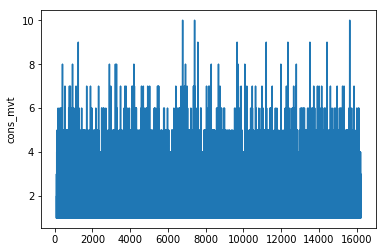

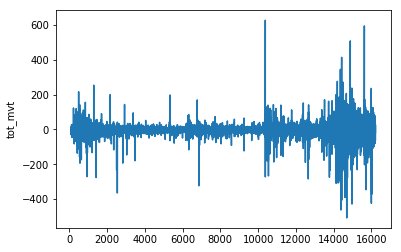

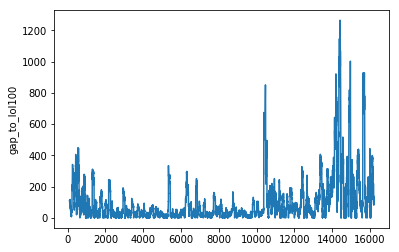

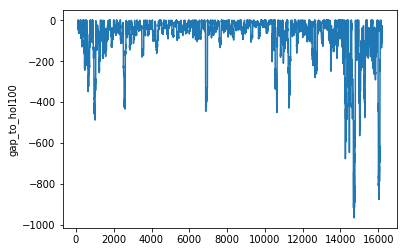

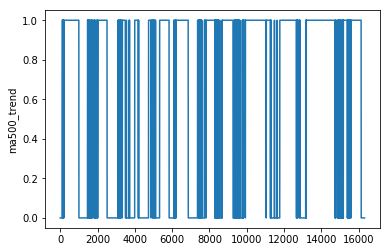

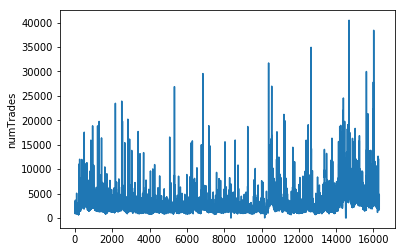

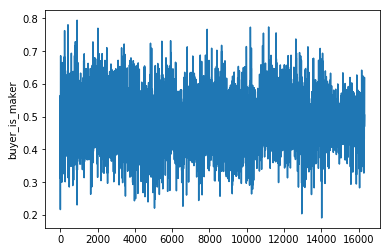

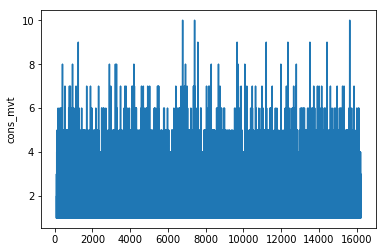

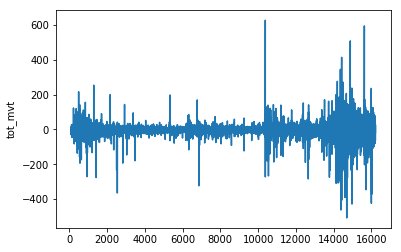

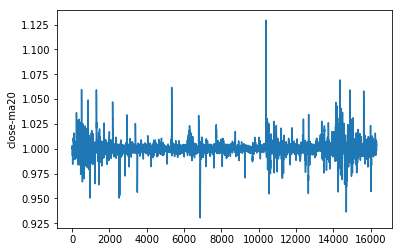

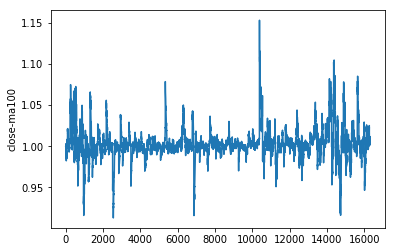

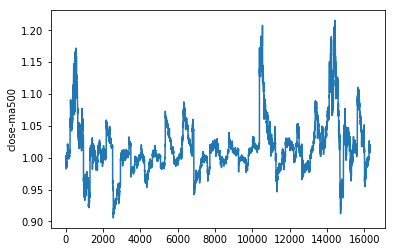

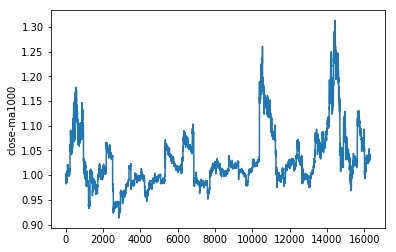

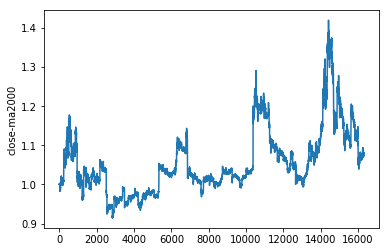

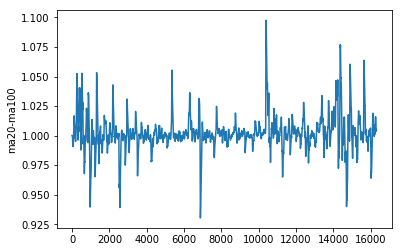

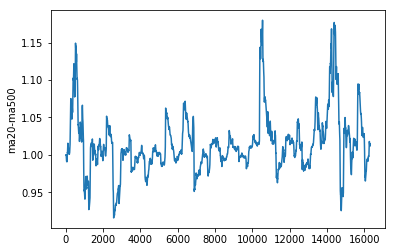

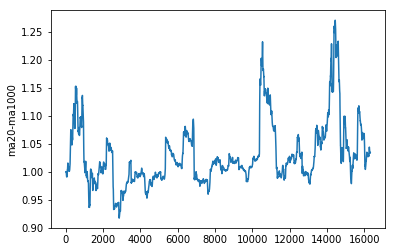

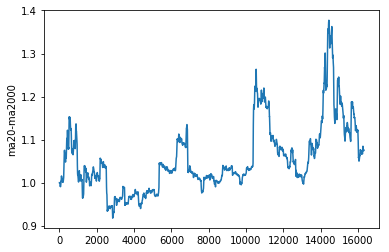

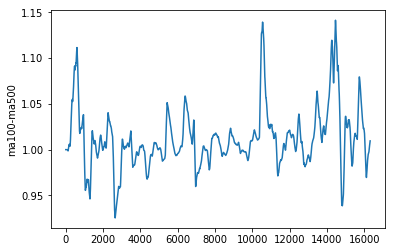

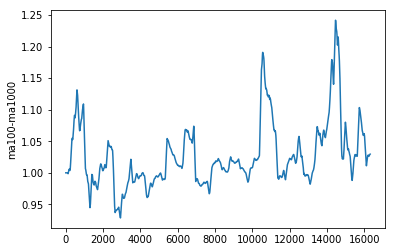

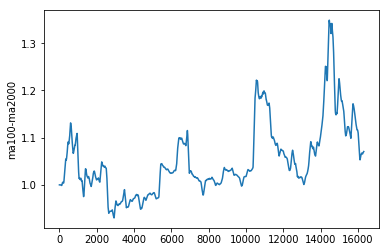

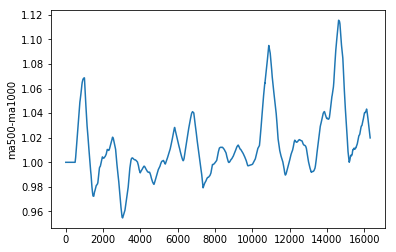

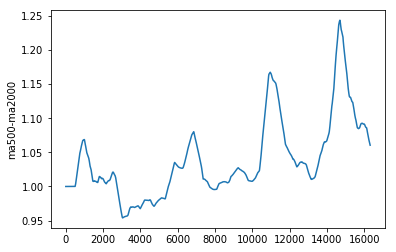

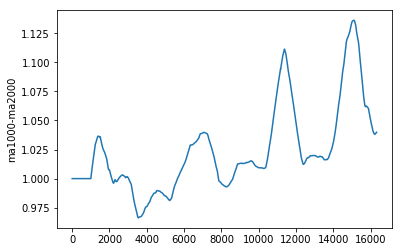

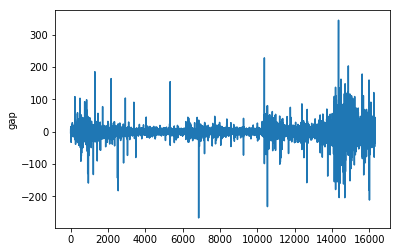

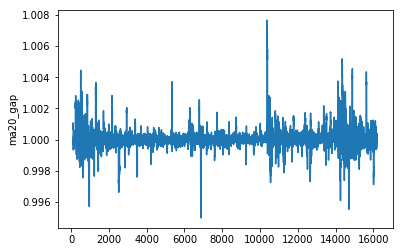

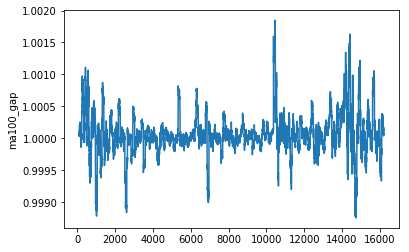

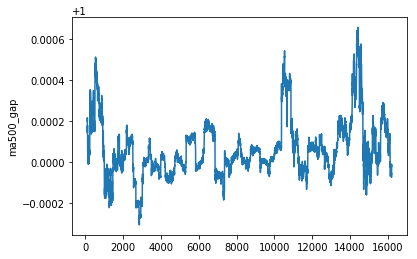

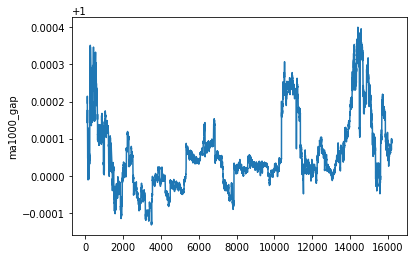

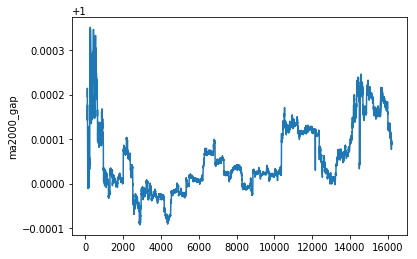

In [282]:

for item in X_columns_final:
    try:
        sns.lineplot(data.index, data[item])
        plt.show()
    except:
        print("error with ",i)
        pass
    
    


<H1> FILE OUTPUT </H1>

* this is where we produce the file that will feed the neural network 
* The last 15% of the dataset are saved for further testing. 
* from the remaining 85%, we extract all records where y = 1, and provide and random sample of records where y = 0. This way, we balance our dataset. This is important because the proportion of y=1 is below 10%,  which could induce a distortion in the training of network.

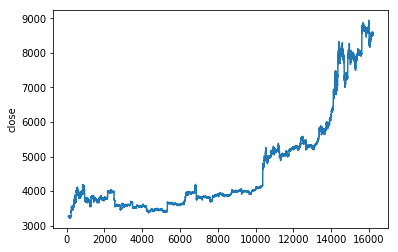

In [23]:
data = pd.read_csv("data binance/with_lowest_of_x_and_trades_15m.csv", index_col = 0)
data = data.dropna()
sns.lineplot(data.index, data.close)
plt.show()

In [24]:
train_lim = int(len(data)*0.7) # training set length
val_lim = int(len(data)*0.85)  # validation set length

min_max_scaler = StandardScaler() # data are normalized
fitted = min_max_scaler.fit(data.loc[:val_lim,X_columns_final])# normalization is fitted to train/val data only
data[X_columns_final] = fitted.transform(data[X_columns_final])# tehn applied to the whole dataset

### orignal code was trying to balance records with var=1 and records with var=0
### taking now a differnt approach where var=1 was set wiht a higher tolerance above. Dataset is already naturally balanced

#data_temp = data # store temporarily 'data
#data = data.loc[time_step:val_lim,:] # skim data to build Train and Val, keep Test range untouched

#index_100 = []
#index_100.extend(data[data.is_l100 + data.is_h100 > 0].index) # collect all records with y = 1
#index_100.extend(data[data.is_l100 + data.is_h100 == 0].sample(len(index_100)).index) # collect a subset of records where y = 0
#index_100.sort()


In [25]:
#data = data_temp #recover complete dataset
#t_f_100 = [(r in index_100) for r in data.index]  # build the range of items for train/val datasets
#data_100 = data[t_f_100] # build the train/val dataset

# encodage des Y
from keras.utils import to_categorical
#data["cat"] = 
data["l1000"] = data.close.rolling(window=50, center = True, min_periods=1).min()
data["h1000"] = data.close.rolling(window=50, center = True, min_periods=1).max()
data["is_l1000"] = data["l1000"] == data["close"]
data["is_h1000"]= data["h1000"] == data["close"]
data["is_l1000"] = data["is_l1000"].astype(int)
data["is_h1000"]= data["is_h1000"].astype(int)
#data["cat"] = data["is_l1000"]+ 2*data["is_h1000"] #no shift
data["cat"] = data["is_l1000"].shift(periods=3,fill_value=0)+ 2*data["is_h1000"].shift(periods=3,fill_value=0) # shift

data_100 = data[:val_lim] # build the train/val dataset
data_test = data[val_lim:len(data)-100] # build the test dataset

categorical_labels = to_categorical(data.cat)
cat_100 = categorical_labels[:val_lim]
cat_test = categorical_labels[val_lim:]


32

In [26]:
# LSTM requires that each record carries it's history. We define depth of history wiht "time_step". This is done for both train/val sets (100 and 1000), and for the test file
history = []
#for i in index_100: 
for i in data_100.index:
    history.append(np.array(data.loc[i+1-time_step:i,X_columns_final].values)) 
data_100.loc[:,"history"] = history

history = []
for i in data_test.index: 
    history.append(np.array(data.loc[i+1-time_step:i,X_columns_final].values)) 
data_test.loc[:,"history"] = history
data_test.to_csv("traintest/test_data_backup_15m.csv")

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [27]:
def toarrays(data,shape1,shape2,shape3):
    c1 = 0
    c2 = 0
    c3 = 0
    out = np.zeros((shape1,shape2,shape3))
    print(out.shape)
    for item in data:
        c2 = 0
        for line in item:
            c3 = 0
            for obj in line:
                out[c1][c2][c3] = obj
                c3+=1
            c2+=1
        c1+=1
                
    return out

def to_train_file(data, y_col,pref):                
    
# with 5 periods shift

    X = toarrays(data["history"],len(data["history"]),time_step,len(X_columns_final))  
    y = y_col
#    z = data[["gap_to_lowest","gap_to_highest"]]    
#    X = np.array([a for a in X])
#    y = np.array(y.values)
            
    train_lim = int(len(data)*0.85) # training set length
 
    X_train = X[0:train_lim]
    X_val = X[train_lim:]
    y_train = y[0:train_lim]
    y_val =  y[train_lim:]
#    z_train = z[0:train_lim]
#    z_val =  z[train_lim:]
    print("X et y train&val shape:{}, {}, {}, {}".format(X_train.shape, y_train.shape,X_val.shape, y_val.shape))
    
    np.save(pref+'x_train_15', X_train)              
    np.save(pref+'x_val_15', X_val)
    np.save(pref+'y_train_15', y_train)                
    np.save(pref+'y_val_15', y_val)  
    
    data.loc[0:train_lim,X_columns_final].to_csv(pref+"x_train_15.csv")
    data.loc[train_lim:val_lim,X_columns_final].to_csv(pref+"x_val_15.csv")
    data.loc[0:train_lim,['is_l100','is_h100'] ].to_csv(pref+"y_train_15.csv")
    data.loc[train_lim:val_lim,['is_l100','is_h100'] ].to_csv(pref+"y_val_15.csv")

    #return X_train
def to_test_file(data, y_col,pref):

    # with 5 periods shift    
    X = toarrays(data["history"],len(data["history"]),time_step,len(X_columns_final)) 
    y = y_col
    print("X et y test shape:{}, {}".format(X.shape, y.shape))
#    X = np.array([a for a in X])
#    y = np.array(y.values)
        
    np.save(pref+'x_test_15',X)
    np.save(pref+'y_test_15',y)
    
    data.loc[:,X_columns_final].to_csv(pref+"x_test_15.csv")
    data.loc[:,['is_l100','is_h100'] ].to_csv(pref+"y_test_15.csv")


to_train_file(data_100,cat_100,'traintest/100_')
to_test_file(data_test,cat_test,'traintest/100_')


(13636, 20, 28)
X et y train&val shape:(11590, 20, 28), (11590, 3), (2046, 20, 28), (2046, 3)
(2307, 20, 28)
X et y test shape:(2307, 20, 28), (2407, 3)


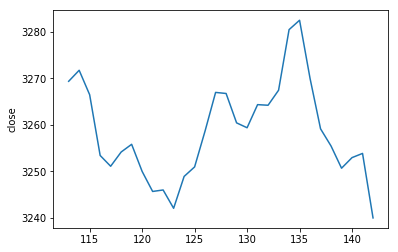

140 openTime                       2018-12-16 15:15:00
close                                      3223.86
closeTime                  2018-12-16 15:15:59.999
high                                       3240.88
low                                           3239
numTrades                                 0.429566
open                                          3240
openTime.1                     2018-12-16 15:15:00
quoteVolume                                87868.7
volume                                     27.1254
xch                                        BTCUSDT
lowest_of_100                              3227.08
highest_of_100                             3449.98
lowest_of_last_100                            3222
highest_of_last_100                        3281.79
avg_of_last_100                            3257.29
avg_of_last_500                            3262.28
avg_of_last_1000                           3253.22
ma20                                       3258.87
ma100                      

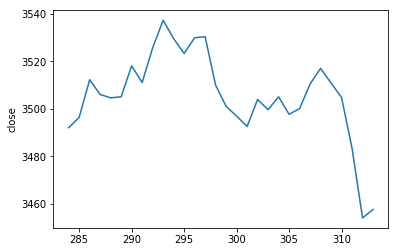

311 openTime                       2018-12-18 10:00:00
close                                      3441.49
closeTime                  2018-12-18 10:00:59.999
high                                       3457.88
low                                        3454.62
numTrades                                 0.655658
open                                        3457.2
openTime.1                     2018-12-18 10:00:00
quoteVolume                                 175099
volume                                     50.6691
xch                                        BTCUSDT
lowest_of_100                              3452.97
highest_of_100                                3759
lowest_of_last_100                         3432.89
highest_of_last_100                        3523.86
avg_of_last_100                            3494.23
avg_of_last_500                            3507.81
avg_of_last_1000                           3506.49
ma20                                       3498.47
ma100                      

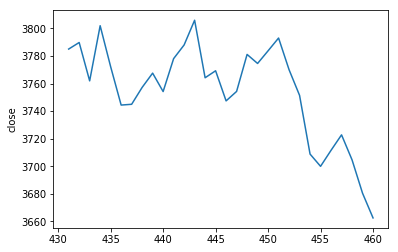

458 openTime                       2018-12-19 22:45:00
close                                      3644.79
closeTime                  2018-12-19 22:45:59.999
high                                       3676.47
low                                        3662.68
numTrades                                  1.88993
open                                       3662.49
openTime.1                     2018-12-19 22:45:00
quoteVolume                                 622766
volume                                     169.901
xch                                        BTCUSDT
lowest_of_100                                 3657
highest_of_100                                4120
lowest_of_last_100                         3630.23
highest_of_last_100                        3736.08
avg_of_last_100                            3702.54
avg_of_last_500                            3769.26
avg_of_last_1000                           3758.41
ma20                                       3740.91
ma100                      

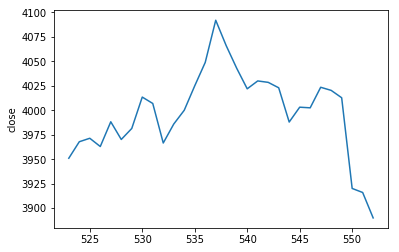

550 openTime                       2018-12-20 21:45:00
close                                         3868
closeTime                  2018-12-20 21:45:59.999
high                                       3898.82
low                                           3880
numTrades                                  2.22472
open                                       3892.32
openTime.1                     2018-12-20 21:45:00
quoteVolume                                 448833
volume                                     115.497
xch                                        BTCUSDT
lowest_of_100                              3784.59
highest_of_100                             4139.99
lowest_of_last_100                            3860
highest_of_last_100                           4028
avg_of_last_100                            3978.11
avg_of_last_500                               4004
avg_of_last_1000                           3927.82
ma20                                       4001.15
ma100                      

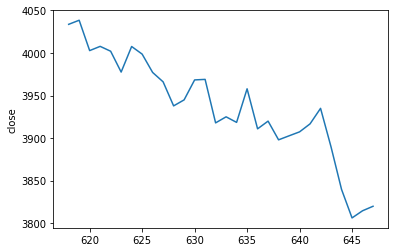

645 openTime                       2018-12-21 21:30:00
close                                      3780.24
closeTime                  2018-12-21 21:30:59.999
high                                          3824
low                                         3818.5
numTrades                                  1.66438
open                                       3819.98
openTime.1                     2018-12-21 21:30:00
quoteVolume                                74035.3
volume                                     19.3824
xch                                        BTCUSDT
lowest_of_100                              3784.59
highest_of_100                             3933.39
lowest_of_last_100                         3771.03
highest_of_last_100                           3938
avg_of_last_100                             3860.8
avg_of_last_500                            3951.79
avg_of_last_1000                           3966.34
ma20                                       3897.14
ma100                      

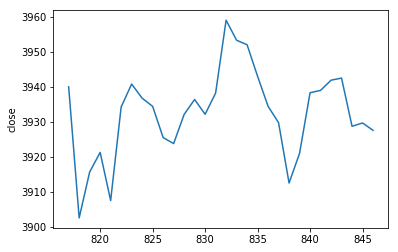

844 openTime                       2018-12-23 23:15:00
close                                         3900
closeTime                  2018-12-23 23:15:59.999
high                                       3927.99
low                                        3925.15
numTrades                               -0.0258791
open                                       3925.51
openTime.1                     2018-12-23 23:15:00
quoteVolume                                30859.6
volume                                     7.85902
xch                                        BTCUSDT
lowest_of_100                              3911.54
highest_of_100                                4198
lowest_of_last_100                            3900
highest_of_last_100                           3954
avg_of_last_100                            3933.26
avg_of_last_500                            3937.99
avg_of_last_1000                           3958.03
ma20                                       3934.57
ma100                      

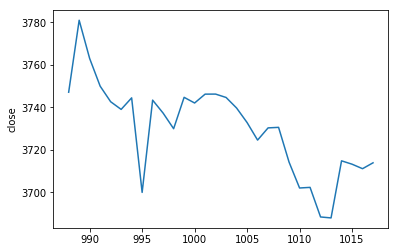

1015 openTime                       2018-12-25 18:00:00
close                                      3672.65
closeTime                  2018-12-25 18:00:59.999
high                                       3717.04
low                                        3713.12
numTrades                                 0.394239
open                                       3711.86
openTime.1                     2018-12-25 18:00:00
quoteVolume                                47250.5
volume                                     12.7226
xch                                        BTCUSDT
lowest_of_100                                 3680
highest_of_100                             3837.15
lowest_of_last_100                         3646.41
highest_of_last_100                        3740.73
avg_of_last_100                            3703.85
avg_of_last_500                            3735.64
avg_of_last_1000                           3758.26
ma20                                       3720.16
ma100                     

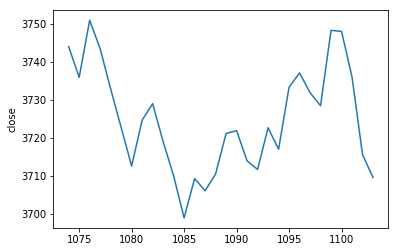

1101 openTime                       2018-12-26 15:30:00
close                                         3660
closeTime                  2018-12-26 15:30:59.999
high                                       3716.33
low                                        3709.66
numTrades                                   1.4247
open                                       3709.48
openTime.1                     2018-12-26 15:30:00
quoteVolume                                 111125
volume                                     29.9563
xch                                        BTCUSDT
lowest_of_100                                 3680
highest_of_100                             3813.98
lowest_of_last_100                         3659.08
highest_of_last_100                        3753.07
avg_of_last_100                             3728.8
avg_of_last_500                            3732.08
avg_of_last_1000                           3754.61
ma20                                       3719.06
ma100                     

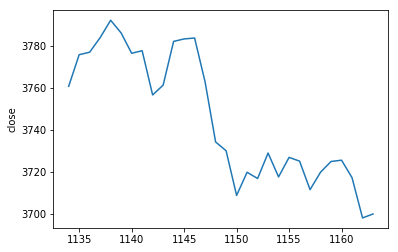

1161 openTime                       2018-12-27 06:30:00
close                                      3688.64
closeTime                  2018-12-27 06:30:59.999
high                                          3703
low                                        3695.12
numTrades                                0.0735797
open                                       3698.26
openTime.1                     2018-12-27 06:30:00
quoteVolume                                54433.3
volume                                     14.7193
xch                                        BTCUSDT
lowest_of_100                              3551.24
highest_of_100                             3760.95
lowest_of_last_100                            3670
highest_of_last_100                        3730.55
avg_of_last_100                            3712.74
avg_of_last_500                            3747.56
avg_of_last_1000                           3739.65
ma20                                       3726.25
ma100                     

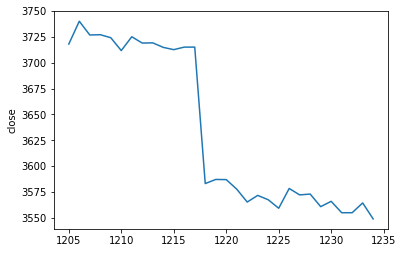

1232 openTime                       2018-12-28 00:15:00
close                                      3547.88
closeTime                  2018-12-28 00:15:59.999
high                                       3557.72
low                                        3551.24
numTrades                                  1.65079
open                                       3549.01
openTime.1                     2018-12-28 00:15:00
quoteVolume                                 216832
volume                                     61.0503
xch                                        BTCUSDT
lowest_of_100                              3551.24
highest_of_100                             3887.25
lowest_of_last_100                            3535
highest_of_last_100                           3577
avg_of_last_100                            3563.12
avg_of_last_500                            3647.49
avg_of_last_1000                           3687.43
ma20                                       3582.54
ma100                     

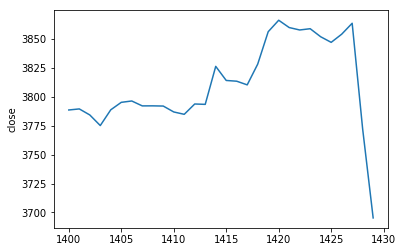

1427 openTime                       2018-12-30 01:00:00
close                                      3677.75
closeTime                  2018-12-30 01:00:59.999
high                                       3721.12
low                                        3708.84
numTrades                                  1.68231
open                                       3696.71
openTime.1                     2018-12-30 01:00:00
quoteVolume                                 523936
volume                                     141.487
xch                                        BTCUSDT
lowest_of_100                              3698.22
highest_of_100                              3903.5
lowest_of_last_100                            3670
highest_of_last_100                           3884
avg_of_last_100                            3831.08
avg_of_last_500                            3813.79
avg_of_last_1000                           3818.89
ma20                                       3816.07
ma100                     

In [20]:
# evaluate options to tag H/L 1000 instead of 100
data["l1000"] = data.close.rolling(window=100, center = True, min_periods=1).min()
data["h1000"] = data.close.rolling(window=100, center = True, min_periods=1).max()
data["is_l1000"] = data["l1000"] == data["close"]
data["is_h1000"]= data["h1000"] == data["close"]
data["is_l1000"] = data["is_l1000"].astype(int)
data["is_h1000"]= data["is_h1000"].astype(int)

do = 10
n = 0
for i in data[data["is_l1000"]==1].index:
    sns.lineplot(data.index[i-126:i-96], data.close[i-129:i-99])
    plt.show()
    print(i, data.loc[i,:])
    n+=1
    if n>do:
        break


In [21]:
data["is_h1000"].sum()

127

In [22]:
data["is_l1000"].sum()

117

<h1> Analysis of data distribution and variables behavior </h1>
* this step intends to deep dive into the data set befor training it
* trying to understand if the approach makes sense and if profit could ultimately come if we guess properly tops and bottoms


In [3]:
data = pd.read_csv("data binance/with_lowest_of_x_and_trades_15m.csv", index_col = 0)
data.head()

,openTime,close,closeTime,high,low,numTrades,open,openTime.1,quoteVolume,volume,...,tot_mvt,is_l100,is_h100,buyer_is_maker,cat,profit,l1000,h1000,is_l1000,is_h1000
99,2018-12-16 05:00:00,3278.04,2018-12-16 05:00:59.999,3293.64,3283.82,0.030644,3273.58,2018-12-16 05:00:00,46285.178252,14.135032,...,0.248762,0,0,0.913660,0,0,3242.08,3285.22,0,0
100,2018-12-16 05:15:00,3285.22,2018-12-16 05:15:59.999,3286.37,3284.84,-0.544913,3277.72,2018-12-16 05:15:00,36933.041431,11.268509,...,0.535807,0,0,1.737630,2,0,3242.08,3285.22,0,1
101,2018-12-16 05:30:00,3273.98,2018-12-16 05:30:59.999,3285.25,3282.04,-0.526978,3285.00,2018-12-16 05:30:00,34927.167363,10.634494,...,-0.765463,0,0,-0.651736,0,0,3242.08,3285.22,0,0
102,2018-12-16 05:45:00,3264.00,2018-12-16 05:45:59.999,3274.00,3270.00,-0.509042,3273.25,2018-12-16 05:45:00,81394.678472,24.882362,...,-1.119485,0,0,-1.889555,0,0,3242.08,3285.22,0,0
103,2018-12-16 06:00:00,3269.96,2018-12-16 06:00:59.999,3271.61,3269.08,-0.643828,3263.99,2018-12-16 06:00:00,78198.773141,23.958398,...,0.306554,0,0,-1.510066,0,0,3242.08,3285.22,0,0


In [404]:
data = pd.read_csv("data binance/with_lowest_of_x_and_trades_15m.csv", index_col = 0)
cols = X_columns_final + ["is_l100","is_h100","gap_to_lowest","gap_to_highest"]

data=data.loc[100:len(data)-1000,cols]
#data=data.loc[100:len(data)-1000,["gap_to_lowest","gap_to_highest","gap","overall_gap","where_in_gap","numTrades","is_l100","is_h100","buyer_is_maker","cons_up","cons_down","total_up","total_down","gap_to_last100_lowest","gap_to_last1000_lowest","gap_to_last100_highest","gap_to_last1000_highest"]]
dl100y = data[data["gap_to_lowest"] < 50].describe()
dl100n = data[data["gap_to_lowest"] > 50].describe()
dh100y = data[data["gap_to_highest"]>-50].describe()
dh100n = data[data["gap_to_highest"]<-50].describe()
result=pd.DataFrame()
for columns in X_columns:
    result["is Low100"] = dl100y[columns] 
    result["is not Low100"] = dl100n[columns]
    result["is High 100"] = dh100y[columns]
    result["is not High100"] = dh100n[columns]
    print("analysis of {}: \n".format(columns),"\n",result,"\n")

    
test_sq = data**2

sns.scatterplot(x=test_sq["cons_up"], y=test_sq["gap_to_last100_lowest"], hue=test_sq["is_l100"])
plt.show()
sns.scatterplot(x=test_sq["cons_up"], y=test_sq["gap_to_last100_highest"], hue=test_sq["is_l100"])
plt.show()
sns.scatterplot(x=test_sq["cons_down"], y=test_sq["gap_to_last100_lowest"], hue=test_sq["is_h100"])
plt.show()
sns.scatterplot(x=test_sq["cons_down"], y=test_sq["gap_to_last100_highest"], hue=test_sq["is_h100"])
plt.show()

g = sns.FacetGrid(test_sq, col="cons_up", hue="is_l100")
g.map(sns.scatterplot,"total_up","gap_to_last100_lowest", alpha=.7)
g.add_legend();

g = sns.FacetGrid(test_sq, col="cons_down", hue="is_l100")
g.map(sns.scatterplot,"total_down","gap_to_last100_lowest", alpha=.7)
g.add_legend();

g = sns.FacetGrid(test_sq, col="cons_up", hue="is_h100")
g.map(sns.scatterplot,"total_up","gap_to_last100_lowest", alpha=.7)
g.add_legend();

g = sns.FacetGrid(test_sq, col="cons_down", hue="is_h100")
g.map(sns.scatterplot,"total_down","gap_to_last100_lowest", alpha=.7)
g.add_legend();

g = sns.FacetGrid(test_sq, col="cons_up", hue="is_l100")
g.map(sns.scatterplot,"total_up","gap_to_last100_highest", alpha=.7)
g.add_legend();

g = sns.FacetGrid(test_sq, col="cons_down", hue="is_l100")
g.map(sns.scatterplot,"total_down","gap_to_last100_highest", alpha=.7)
g.add_legend();

g = sns.FacetGrid(test_sq, col="cons_up", hue="is_h100")
g.map(sns.scatterplot,"total_up","gap_to_last100_highest", alpha=.7)
g.add_legend();

g = sns.FacetGrid(test_sq, col="cons_down", hue="is_h100")
g.map(sns.scatterplot,"total_down","gap_to_last100_highest", alpha=.7)
g.add_legend();

#sns.scatterplot(x=data["cons_down"], y=data["total_down"], hue=data["is_l100"])
#sns.scatterplot(x=data["cons_up"], y=data["total_up"], hue=data["is_h100"])
#sns.scatterplot(x=data["cons_down"], y=data["total_down"], hue=data["is_l100"])
#plt.show()

'''
sns.boxplot(x=data['is_l100'], y=data.loc[data["gap"]**2 < 10,"gap"])
plt.show()
sns.boxplot(x=data['is_h100'], y=data.loc[data["gap"]**2 < 10,"gap"])
plt.show()
sns.boxplot(x=data['is_l100'], y=data.loc[data["gap"]**2 < 10,"gap"])
plt.show()
sns.boxplot(x=data['is_h100'], y=data.loc[data["gap"]**2 < 10,"gap"])
plt.show()

sns.boxplot(x=data["is_h100"],y=data["gap_to_avg_of_last_100"])
plt.show()
sns.boxplot(x=data["is_h100"],y=data["gap_to_avg_of_last_500"])
plt.show()
sns.boxplot(x=data["is_h100"],y=data["gap_to_avg_of_last_1000"])
plt.show()
'''
print("is L100 \n",data[data["is_l100"]==1].describe(), "is not L100 \n",data[data["is_l100"]==0].describe())
print("is H100 \n",data[data["is_h100"]==1].describe(), "is not H100 \n",data[data["is_h100"]==0].describe())


'''
for i in X_columns_final:
    print("behavior of {} for low spot \n".format(i))
    sns.boxplot(x=data["is_l100"],y=data[i])
    plt.show()
    print("behavior of {} for high spot \n".format(i))
    sns.boxplot(x=data["is_h100"],y=data[i])
    plt.show()


for i in X_columns_final:
    print("track l100 \n")
    sns.lineplot(x=data.index,y=data[i],hue=data["is_l100"])
    plt.show
    print("track h100 \n")
    sns.lineplot(x=data.index,y=data[i],hue=data["is_h100"])
    plt.show
    

print("behavior of volume for low spot \n")
sns.boxplot(x=data['is_l100'], y=data["numTrades"])
plt.show()

print("behavior of volume for high spot \n")
sns.boxplot(x=data['is_h100'], y=data["numTrades"])
plt.show()

print("behavior of buyer_is_maker for low spot \n")
sns.boxplot(x=data["is_l100"],y=data.loc[data["buyer_is_maker"] > .4,"buyer_is_maker"])
plt.show()

print("behavior of buyer is maker for high spot \n")
sns.boxplot(x=data["is_h100"],y=data.loc[data["buyer_is_maker"] > .4,"buyer_is_maker"])
plt.show()

print("behavior of buyer is maker for high spot \n")
sns.boxplot(x=data["is_l100"],y=data.loc[data["buyer_is_maker"] > .4,"buyer_is_maker"])
plt.show()
'''


analysis of gap: 
 
           is Low100  is not Low100  is High 100  is not High100
count  10020.000000    5123.000000  7271.000000     7865.000000
mean       0.844557      -0.806237    -0.575880        1.085240
std       11.943364      24.248112    13.862481       19.667247
min      -78.950000    -267.110000  -267.110000     -204.050000
25%       -3.390000      -6.875000    -3.740000       -4.860000
50%        0.390000      -0.030000     0.070000        0.530000
75%        4.210000       6.910000     3.645000        6.260000
max      345.100000     228.540000   164.340000      345.100000 



KeyError: 'overall_gap'

In [ ]:
sns.lineplot(data.index,data.gap)
plt.show()
sns.lineplot(data.index,test["buy?"])
sns.lineplot(data.index,test["sell?"])


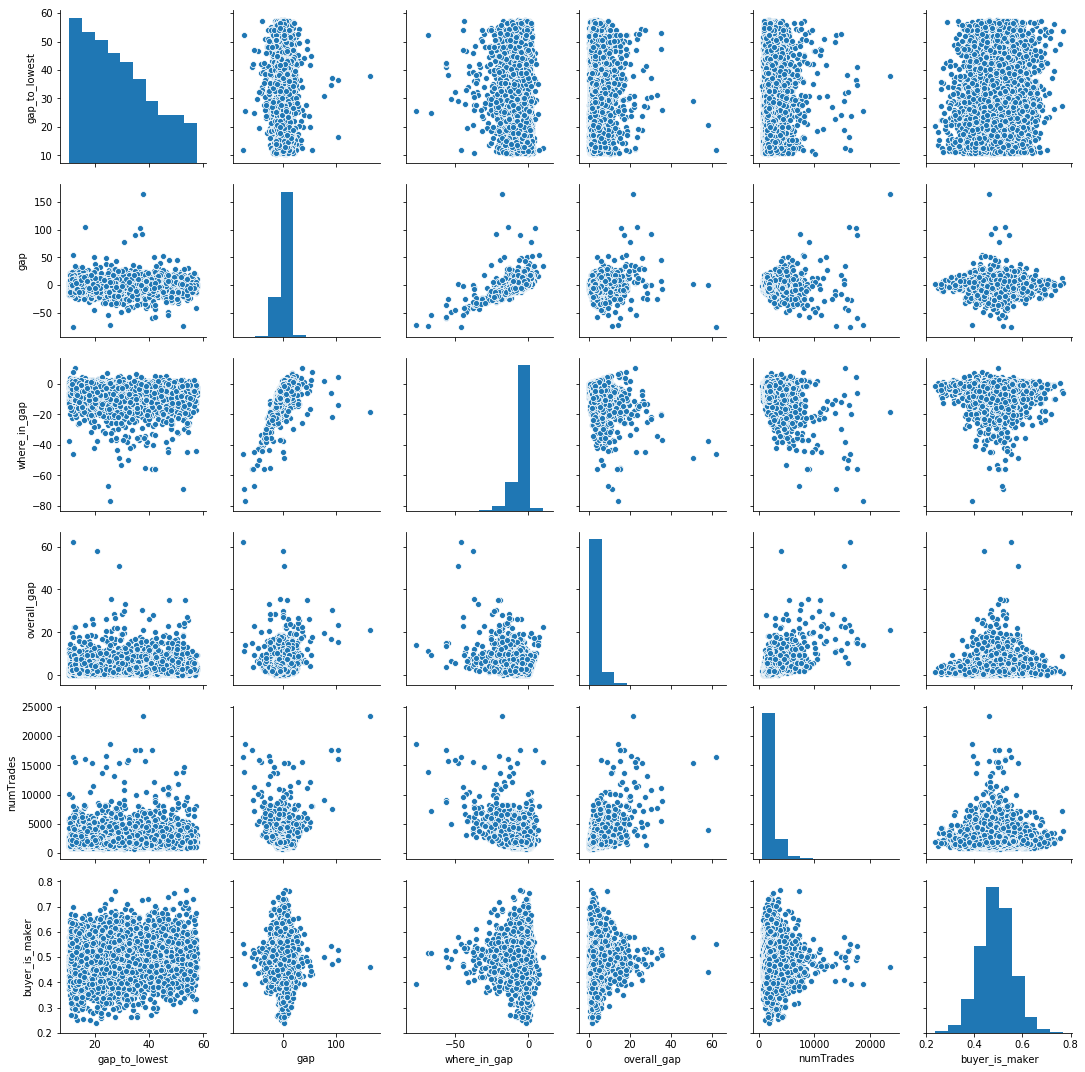

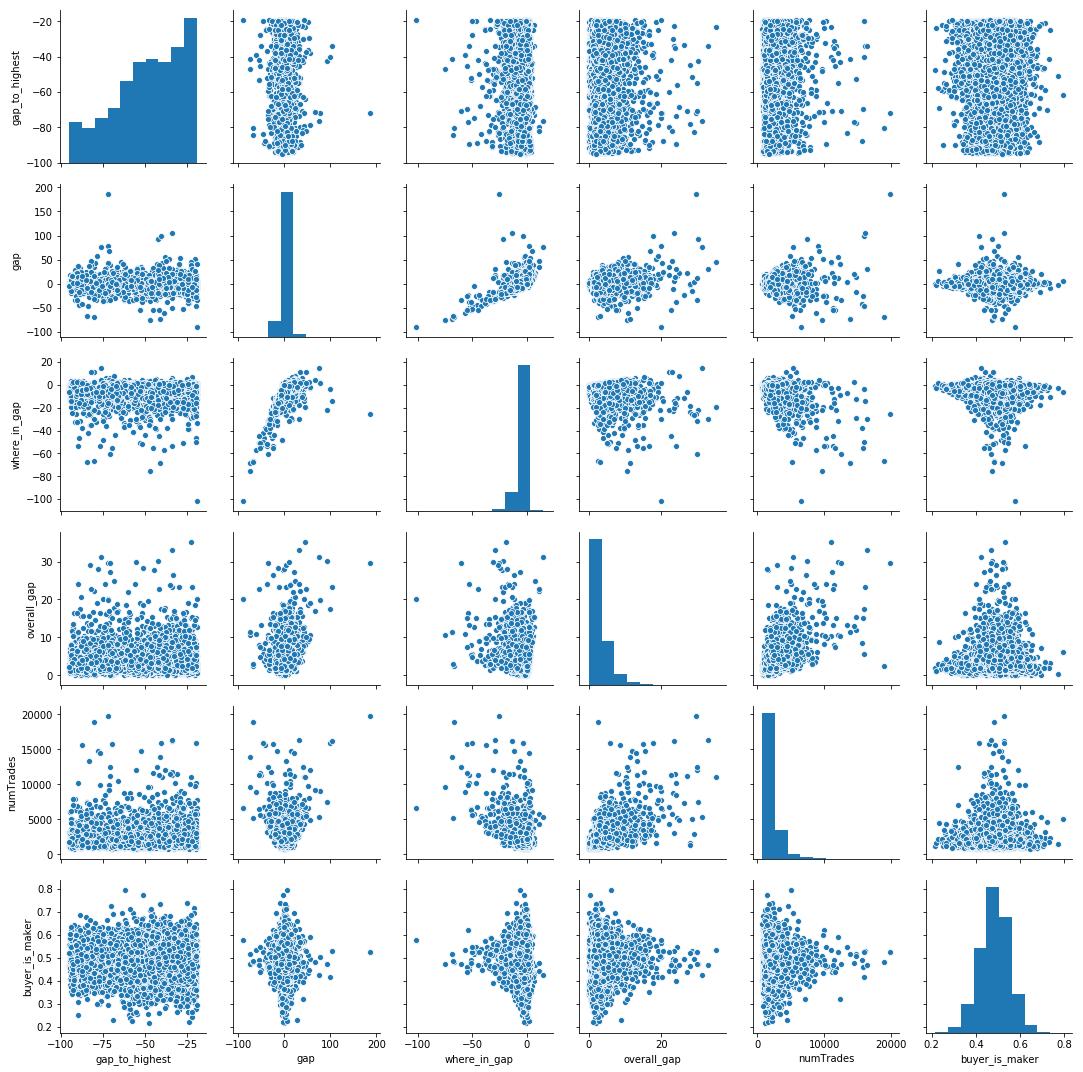

In [133]:
for i in ["gap_to_lowest","gap_to_highest"]:
    pair_data = data[(data[i] > data[i].quantile(.25)) &(data[i] < data[i].quantile(.75))]
    sns.pairplot(pair_data[[i,"gap","where_in_gap","overall_gap","numTrades","buyer_is_maker"]])
    plt.show()


In [116]:
data.describe()

,gap_to_lowest,gap_to_highest,gap,overall_gap,where_in_gap,numTrades,is_l100,is_h100,buyer_is_maker
count,12578.000000,12578.000000,12584.000000,12584.000000,12584.000000,12612.000000,12612.000000,12612.000000,12584.000000
mean,50.420402,-79.525756,0.164836,3.636434,-4.916816,2324.492943,0.063670,0.044085,0.489244
std,71.412471,101.766456,11.869669,3.656801,8.533559,1820.222522,0.244173,0.205292,0.070006
min,0.000000,-856.990000,-267.110000,0.010000,-266.720000,0.000000,0.000000,0.000000,0.216549
25%,10.602500,-94.952500,-3.662500,1.680000,-6.220000,1430.000000,0.000000,0.000000,0.444174
50%,26.580000,-46.000000,0.240000,2.570000,-2.830000,1837.000000,0.000000,0.000000,0.489782
75%,57.487500,-19.490000,4.070000,4.230000,-0.825000,2556.000000,0.000000,0.000000,0.534222
max,483.220000,0.000000,228.540000,87.920000,14.745000,31735.000000,1.000000,1.000000,0.794657


<h1> Benchmark vs Random Forest

In [151]:
# benchmark vs classic Decision tree model

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier as DTClass
from sklearn.ensemble import RandomForestClassifier as RFClass
from sklearn.preprocessing import StandardScaler

# let's shift out Y's of 5 period to let new trend install and give better chance to detect it

X_train = pd.read_csv("traintest/100_x_train_15.csv", index_col=0)              
y_train = pd.read_csv("traintest/100_y_train_15.csv", index_col=0).shift(periods=5,fill_value=0)
y_train_buy = pd.read_csv("traintest/100_y_train_15.csv", index_col=0)["is_l100"].shift(periods=5,fill_value=0)
y_train_sell = pd.read_csv("traintest/100_y_train_15.csv", index_col=0)["is_h100"].shift(periods=5,fill_value=0)  

X_val = pd.read_csv("traintest/100_x_val_15.csv", index_col=0) 
y_val = pd.read_csv("traintest/100_y_val_15.csv", index_col=0).shift(periods=5,fill_value=0)
y_val_buy = pd.read_csv("traintest/100_y_val_15.csv", index_col=0)["is_l100"].shift(periods=5,fill_value=0) 
y_val_sell = pd.read_csv("traintest/100_y_val_15.csv", index_col=0)["is_h100"].shift(periods=5,fill_value=0)  

#z_train = pd.read_csv("data binance/z_train_15.csv", index_col=0)              
#z_val = pd.read_csv("data binance/z_val_15.csv", index_col=0)  

In [152]:
print(len(y_train[y_train["is_l100"]==1]), len(y_train[y_train["is_h100"]==1]),len(y_train[y_train["is_l100"] + y_train["is_h100"] == 0]))


166 116 7916


In [150]:
# on mesure la précision du modèle sur 5 subsets de notre jeu de données "train", afin de limiter l'influence des paramètres aléatoires
cv_fold = 5
model = RFClass(n_estimators = 1000)
scores = cross_val_score(model, X_train, y_train['is_l100'], cv=cv_fold)

sns.boxplot(scores)

KeyboardInterrupt: 

In [232]:
#params = {'verbose':[1],'random_state':[0,1],'n_estimators':[100,500,1000,5000],'criterion':['gini','entropy'],'max_depth':[10,50,100,150]}
#model = RFClass()
#clf = GridSearchCV(model, params, cv=5)
#clf.fit(X_train, y_train["is_l100"])

In [157]:
sell_model = RFClass()
sell_model.max_depth = 10
sell_model.n_estimators = 200
sell_model.criterion = "gini"
sell_model.fit(X_train,y_train_sell)
print(sell_model.score(X_train,y_train_sell),sell_model.score(X_val,y_val_sell))

0.9984142473774091 1.0


In [159]:
buy_model = RFClass()
buy_model.max_depth = 15
buy_model.n_estimators = 200
buy_model.criterion = "gini"
buy_model.fit(X_train,y_train_buy)
print(buy_model.score(X_train,y_train_buy),buy_model.score(X_val,y_val_buy))

0.9998780190290315 0.981263011797363


In [160]:
data_test = pd.read_csv("traintest/test_data_backup_15m.csv")
X_test = data_test[X_columns_final][:-100]
y_test_buy = data_test["is_l100"][:-100]
y_test_sell = data_test["is_h100"][:-100]

In [161]:
print("SELL : score train: {}; score val:{}, score test {}".format(sell_model.score(X_train,y_train_sell),sell_model.score(X_val,y_val_sell),sell_model.score(X_test,y_test_sell)))
print("BUY : score train: {}; score val:{}, score test {}".format(buy_model.score(X_train,y_train_buy),buy_model.score(X_val,y_val_buy),buy_model.score(X_test,y_test_buy)))


SELL : score train: 0.9984142473774091; score val:1.0, score test 0.871306631648063
BUY : score train: 0.9998780190290315; score val:0.981263011797363, score test 0.9402495075508864


In [162]:
results = data_test[X_columns_final][:-100]
results["gap_to_lowest"]=data_test["gap_to_lowest"][:-100]
results["gap_to_highest"]=data_test["gap_to_highest"][:-100]
results["true_buy"]= y_test_buy
results["true_sell"]= y_test_sell
results["test_buy"] = pd.DataFrame(buy_model.predict(X_test))[0]
results["test_sell"] = pd.DataFrame(sell_model.predict(X_test))[0]
results.to_csv("analyse_.csv")

In [168]:
y_test_sell.sum()

5

In [164]:
#results["test_buy_1"] = results["test_buy"].apply(lambda x: 1 if x > .99 else 0)
#results["test_sell_1"] = results["test_sell"].apply(lambda x: 1 if x > .90 else 0)

from sklearn.metrics import classification_report, confusion_matrix
print("confusion matrix on buy: \n{}".format(confusion_matrix(results["test_buy"], results["true_buy"], labels=[1,0])))
print("confusion matrix on sell: \n{}".format(confusion_matrix(results["test_sell"],results["true_sell"],  labels=[1,0])))


confusion matrix on buy: 
[[   0    0]
 [  91 1432]]
confusion matrix on sell: 
[[   3  194]
 [   2 1324]]


<h1> Benchmark vs SVM


In [210]:
from sklearn import svm


In [391]:
#svc_params = {'gamma':['auto','scale'],'random_state':[0,1],'C':[.5,.75,1,3,5],'kernel':['linear','poly','rbf','sigmoid'],}
svc_params = {'gamma':['scale'],'C':[0.5,1,3],'kernel':['rbf'],}
svc = svm.SVC(probability=True, decision_function_shape='ovo', gamma='scale',C=1,kernel="rbf")
svc_cv = GridSearchCV(svc, svc_params, cv=5)
#svc_sell = GridSearchCV(svc, svc_params, cv=5)

y_train["svm_y_train"] = y_train["is_h100"] - y_train["is_l100"]
y_val["svm_y_val"] = y_val["is_h100"] - y_val["is_l100"]
y_test_svm = y_test_sell - y_test_buy
svc.fit(X_train, y_train["svm_y_train"])
print("train done")
#svc_sell.fit(X_train, y_train_sell)
#print("sell done")

train done


In [397]:
#print("SELL : score train: {}; score val:{}, score test {}".format(svc_sell.score(X_train,y_train_sell),svc_sell.score(X_val,y_val_sell),svc_sell.score(X_test,y_test_sell)))
#print("BUY : score train: {}; score val:{}, score test {}".format(svc_buy.score(X_train,y_train_buy),svc_buy.score(X_val,y_val_buy),svc_buy.score(X_test,y_test_buy)))
print("SVM : score train: {}; score val:{}, score test {}".format(svc.score(X_train, y_train["svm_y_train"]),svc.score(X_val,y_val["svm_y_val"]),svc.score(X_test,y_test_svm)))
results = data_test[X_columns_final][:-100]
results["gap_to_lowest"]=data_test["gap_to_lowest"][:-100]
results["gap_to_highest"]=data_test["gap_to_highest"][:-100]
results["true_buy"]= y_test_buy
results["true_sell"]= y_test_sell
results["test_buy_sell"] = pd.DataFrame(svc.predict(X_test))
#results["test_sell_1"] = pd.DataFrame(svc_cv.predict(X_test))[2]
results.to_csv("analyse_svc.csv")


SVM : score train: 0.5610198300283286; score val:0.34242232086239693, score test 0.5693606755126659


In [ ]:
results.sort_values("test_buy_sell")

In [ ]:
#results["test_buy_1"] = results["test_buy"].apply(lambda x: 1 if x > .3 else 0)
#results["test_sell_1"] = results["test_sell"].apply(lambda x: 1 if x > .85 else 0)

from sklearn.metrics import classification_report, confusion_matrix
print("confusion matrix on buy: \n{}".format(confusion_matrix(results["test_buy_1"], results["true_buy"], labels=[1,0])))
print("confusion matrix on sell: \n{}".format(confusion_matrix(results["test_sell_1"],results["true_sell"],  labels=[1,0])))


<h1> How much would we have made if we had been able to spot the best 10 trades?
    

In [2]:
data = pd.read_csv("data binance/with_lowest_of_x_and_trades_15m.csv", index_col = 0)

9777.8 eur generated, 
 60  deals done, 

market growth: 5292.9


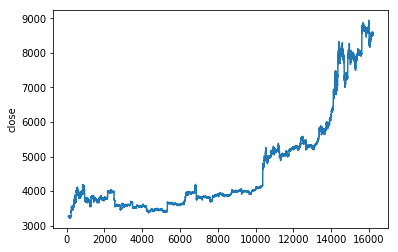

In [5]:
def calc_benef(simul, shift):
    look_for = 'sell'
    buy_price = float(simul.head(1)["close"].values)
    simul["profit"]=0
    simul["is_l1000_sh"]=simul["is_l1000"].shift(periods=shift,fill_value=0)
    simul["is_h1000_sh"]=simul["is_h1000"].shift(periods=shift,fill_value=0)
    buy_time = 0
    for i in simul.index:
        if look_for == 'buy' and simul.loc[i,"is_l1000_sh"]==1:
            buy_price = simul.loc[i,"close"]
            buy_time = i
            look_for = "sell"
    #        print("bought on {} for {}".format(i,data.loc[i,"close"]))
        elif (look_for == 'sell' and simul.loc[i,"is_h1000_sh"]==1 and ((simul.loc[i,"close"] / buy_price) > 1.01)) or (look_for=="sell" and i == simul.index.max() and (simul.loc[i,"close"] / buy_price) > 1.01):
            simul.loc[i,"profit"] = 0.9985*simul.loc[i,"close"] - buy_price # a penalty of 1% is applied to represent trade fees applied by excahnge  platform
            simul.loc[i,"immo_time"] = i - buy_time
            look_for = "buy"

    print(round(simul["profit"].sum(),2),"eur generated, \n",len(simul[simul["profit"]!=0])," deals done, \n", )
#   print( "zoom on profit obtained:\n", data[["profit","immo_time"]].describe())
#sns.boxplot(y = data.profit[data["profit"]<60])
#    print("\n median = {} and mean = {}".format(data["profit"].median(),data["profit"].mean() ))
#    plt.show()
#    sns.boxplot(y = simul["profit"])
    #        print("sold on {} for {}, profit {}".format(i,data.loc[i,"close"], data.loc[i,"profit"]))
#        if i in check_steps:
#            print("over {}".format(i),datetime.datetime.now())


calc_benef(data, 3)

mkt_g = round(data.loc[data.index.max(),"close"] - float(data.head(1)["close"].values) ,2 )
print("market growth:",mkt_g)
#round(data.loc[len(data)-1,"close"] - data.loc[0,"close"],2)
sns.lineplot(data.index, data["close"])
plt.show()
        

**Profit distribution** 

* zooming on 25/75 quartiles (1st graph) shows that half of transactions hits a profits from 0 to 35
* but the global picture (second graph) shows that thanks to occasional exceptional gains, the average gain is positive
* this is how we get a median of 88 along with a mean of 138
* we also notice the the average investment duration is 118*15  minutes between buy and sell

In [24]:
data[data["profit"]!=0]


,openTime,close,closeTime,high,low,numTrades,open,openTime.1,quoteVolume,volume,...,buyer_is_maker,cat,l1000,h1000,is_l1000,is_h1000,profit,is_l1000_sh,is_h1000_sh,immo_time
271,2018-12-18 00:00:00,3489.00,2018-12-18 00:00:59.999,3496.77,3491.73,0.064340,3483.05,2018-12-18 00:00:00,126656.669926,36.333215,...,-1.454504,0,3258.43,3559.87,0,0,176.0700,0,1,271.0
435,2018-12-19 17:00:00,3757.18,2018-12-19 17:00:59.999,3775.00,3767.04,1.681225,3743.68,2018-12-19 17:00:00,203194.041802,54.319457,...,0.162174,0,3644.79,3887.06,0,0,239.8682,0,1,114.0
580,2018-12-21 05:15:00,4005.00,2018-12-21 05:15:59.999,4006.92,4000.25,0.676854,3988.94,2018-12-21 05:15:00,142735.616156,35.811769,...,-1.999770,0,3868.00,4116.75,0,0,265.2100,0,1,112.0
811,2018-12-23 15:00:00,3958.63,2018-12-23 15:00:59.999,3996.78,3985.00,1.252411,3995.64,2018-12-23 15:00:00,203511.560576,51.009274,...,0.857101,0,3900.00,4150.00,0,0,112.1237,0,1,156.0
10390,2019-04-02 09:45:00,4646.03,2019-04-02 09:45:59.999,4653.96,4647.35,2.527440,4650.99,2019-04-02 09:45:00,354160.330075,76.200418,...,0.643120,0,4135.84,4798.65,0,0,454.7297,0,1,9536.0
10819,2019-04-06 21:00:00,5146.71,2019-04-06 21:00:59.999,5147.24,5144.36,0.184995,5141.85,2019-04-06 21:00:00,246264.116080,47.917116,...,-0.748232,0,4960.00,5166.00,0,0,135.0529,0,1,261.0
10953,2019-04-08 06:30:00,5246.84,2019-04-08 06:30:59.999,5262.10,5250.70,0.082819,5223.26,2019-04-08 06:30:00,31034.384878,5.939173,...,-0.276695,0,5046.16,5296.09,0,0,74.3716,0,1,39.0
11215,2019-04-11 00:00:00,5257.00,2019-04-11 00:00:59.999,5278.00,5273.22,-0.037836,5272.00,2019-04-11 00:00:00,127959.367736,24.256908,...,0.120472,0,5055.61,5380.50,0,0,48.0200,0,1,223.0
11622,2019-04-15 05:45:00,5136.88,2019-04-15 05:45:59.999,5145.00,5142.38,-0.646545,5135.98,2019-04-15 05:45:00,41367.864809,8.054009,...,1.742051,0,5045.17,5160.00,0,0,99.0112,0,1,344.0
11855,2019-04-17 16:00:00,5168.75,2019-04-17 16:00:59.999,5186.99,5183.33,-0.113925,5184.84,2019-04-17 16:00:00,51422.454406,9.916295,...,0.454060,0,5163.43,5247.89,0,0,73.4025,0,1,158.0


* Focusing on the top trades (ranked by descending profit) we can also conclude that being selective is key. Most trades will generate a profit close to 0 or even negative, mostly because of trading fees. 
* however, if we manage to trigger trades only on best situations, we can be largely positive.
* the top 20 trades of the last 5 months alone would have generated a nearly 100% profit.

In [461]:
n_trades = 9
top_trades = round(data.sort_values("profit", ascending=False).head(n_trades)[["immo_time","profit"]].describe(),2)
achieved_profit = top_trades["profit"]["mean"]*n_trades
mkt_g = round(data.loc[len(data)-1,"close"] - data.loc[0,"close"],2)

print("total gain realised with {} trades:{}".format(n_trades,achieved_profit))
print("natural growth of market: {} - {} = {}".format(data.loc[0,"close"],data.loc[len(data)-1,"close"],mkt_g))
print("{} best trades outperforms market: {}%".format(n_trades,round(achieved_profit / mkt_g * 100),2))




KeyError: 0

* Let's be more realistic and assume that we get the top 20 and worst 20 of the trades
* the trades still outperform the market 

In [16]:
n_trades = 20
top_trades = round(data.sort_values("profit", ascending=False).head(n_trades)[["immo_time","profit"]].describe(),2)
worst_trades = round(data.sort_values("profit", ascending=True).head(n_trades)[["immo_time","profit"]].describe(),2)

achieved_profit = top_trades["profit"]["mean"]*n_trades + worst_trades["profit"]["mean"]*n_trades
mkt_g = round(data.loc[len(data)-1,"close"] - data.loc[0,"close"],2)

print("total gain realised with {} best and worst trades:{}".format(n_trades,achieved_profit))
print("natural growth of market: {} - {} = {}".format(data.loc[0,"close"],data.loc[len(data)-1,"close"],mkt_g))
print("{} best trades outperforms market: {}%".format(n_trades,round(achieved_profit / mkt_g * 100),2))




total gain realised with 20 best and worst trades:6578.2
natural growth of market: 3247.03 - 5403.35 = 2156.32
20 best trades outperforms market: 305.0%


<h1>alternative test

In [3]:
data = pd.read_csv("data binance/with_lowest_of_x_and_trades_15m.csv", index_col=0) 
data=data.dropna()
look_for = 'wait'
buy_price = .0

for i in data:
    if look_for='buy':
        if i["ma500_trend"]==1 and i["close"]==1:
            buy_price = i["close"]
            buy_time = i
            look_for = "sell"
            print('buy',i,buy_price)
        
        if data.loc[i,"ma500_trend"]==1:
            buy_price = data.loc[i,"close"]
            buy_time = i
            look_for = "sell"
            print('buy',i,buy_price)
    
        
        if look_for='buy':
            buy_price = data.loc[i,"close"]
            buy_time = i
            look_for = "sell"
            print('buy',i,buy_price)
        

# achat quand MA500 commence a monter, 
# vente opportuniste cours < MA500 et que MA500>MA2000
# vente defense si cours <


    
'''    
# marché montant
    wait -=1
    if data.loc[i,"ma500_trend"]==1 and wait < 0:
# acheter en creux
        if look_for == 'buy' and data.loc[i,"close"] < data.loc[i,"ma500"]:        
            buy_price = data.loc[i,"close"]
            buy_time = i
            look_for = "sell"
            print('buy',i,buy_price)
            wait = 100
# vendred si le cours dépasse les 2 MA
        elif look_for == 'sell' and data.loc[i,"close"] < data.loc[i,"ma20"] and data.loc[i,"ma20"] > data.loc[i,"ma100"] and data.loc[i,"close"] > buy_price*1.02:
            print('sell opp',i,data.loc[i,"close"])
            data.loc[i,"profit"] = 0.99*data.loc[i,"close"] - buy_price # a penalty of 1% is applied to represent trade fees applied by excahnge  platform
            data.loc[i,"immo_time"] = i - buy_time 
            look_for = "buy"
            wait = 100
# vendre si le rebond ne fonctionne pas
        elif look_for == "sell" and data.loc[i,"close"] < data.loc[i,"ma500"]:
            print('!!!sell def',i,data.loc[i,"close"])
            data.loc[i,"profit"] = 0.99*data.loc[i,"close"] - buy_price # a penalty of 1% is applied to represent trade fees applied by excahnge  platform
            data.loc[i,"immo_time"] = i - buy_time 
            look_for = "wait"
    if wait < 0 and look_for == "wait" and data.loc[i,"close"] > data.loc[i,"ma500"] and data.loc[i,"close"] > data.loc[i,"ma20"] :
            look_for = "buy"

#    if i in check_steps:
#        print("over {}".format(i),datetime.datetime.now())     
'''

buy 948 3836.07
!!!sell def 1575 3736.07
buy 1590 3736.17
!!!sell def 1701 3710.01
buy 1954 3757.55
!!!sell def 2091 3768.1
buy 2126 3772.22
sell opp 2231 3968.99
buy 2509 3817.58
!!!sell def 3545 3534.0
buy 3712 3585.59
!!!sell def 3998 3545.3
buy 4116 3547.76
!!!sell def 4866 3445.6
buy 4920 3453.9
!!!sell def 5038 3455.31
buy 5050 3456.67
sell opp 5352 3648.61
buy 5782 3616.63
!!!sell def 6185 3613.0
buy 7397 3802.01
!!!sell def 7523 3816.66
buy 7529 3813.52
sell opp 7985 3890.15
buy 8266 3883.02
!!!sell def 8391 3894.1
buy 9321 3985.26
!!!sell def 9437 3995.67
buy 9459 3995.45
!!!sell def 9560 3989.79
buy 11237 5125.76
!!!sell def 11482 5050.0


In [4]:
data = pd.read_csv("data binance/with_lowest_of_x_and_trades_15m.csv", index_col=0) 
#data["ma500"]=data["close"].rolling(500,min_periods=1).mean()
#data["ma1000"]=data["close"].rolling(1000,min_periods=1).mean()
#data["ma1500"]=data["close"].rolling(1500,min_periods=1).mean()
#data["ma2000"]=data["close"].rolling(2000,min_periods=1).mean()
#data["ma500_acc"] = 0
#for i in data.index:
#    try: 
#        data.loc[i,"ma500_acc"] = (data.loc[i,"ma500"] - data.loc[i-1,"ma500"])**2/(data.loc[i-1,"ma500"] - data.loc[i-2,"ma500"])**2
#    except:
#        data.loc[i,"ma500_acc"] = 0

In [7]:
data.dropna()

,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,openTime,close,closeTime,high,low,numTrades,open,...,ma100,ma500,cons_mvt,tot_mvt,ma500_trend,buyer_is_maker,ma1000,ma1500,ma2000,ma500_acc
99,99,99,99,2018-12-16 05:00:00,3278.04,2018-12-16 05:00:59.999,3293.64,3283.82,2393,3273.58,...,3215.6381,3215.638100,1.0,4.46,1,0.553220,3215.638100,3215.638100,3215.638100,1.150802
100,100,100,100,2018-12-16 05:15:00,3285.22,2018-12-16 05:15:59.999,3286.37,3284.84,1334,3277.72,...,3216.0200,3216.327030,2.0,11.96,1,0.611154,3216.327030,3216.327030,3216.327030,1.194606
101,101,101,101,2018-12-16 05:30:00,3273.98,2018-12-16 05:30:59.999,3285.25,3282.04,1367,3285.00,...,3216.2883,3216.892255,2.0,-22.04,1,0.443155,3216.892255,3216.892255,3216.892255,0.673121
102,102,102,102,2018-12-16 05:45:00,3264.00,2018-12-16 05:45:59.999,3274.00,3270.00,1400,3273.25,...,3216.3661,3217.349612,3.0,-31.29,1,0.356123,3217.349612,3217.349612,3217.349612,0.654737
103,103,103,103,2018-12-16 06:00:00,3269.96,2018-12-16 06:00:59.999,3271.61,3269.08,1152,3263.99,...,3216.5757,3217.855481,1.0,5.97,1,0.382805,3217.855481,3217.855481,3217.855481,1.223393
104,104,104,104,2018-12-16 06:15:00,3266.11,2018-12-16 06:15:59.999,3270.66,3269.26,873,3269.53,...,3216.6582,3218.315048,2.0,-6.84,1,0.435503,3218.315048,3218.315048,3218.315048,0.825317
105,105,105,105,2018-12-16 06:30:00,3270.94,2018-12-16 06:30:59.999,3271.53,3268.05,900,3265.67,...,3216.7345,3218.811509,1.0,5.27,1,0.479862,3218.811509,3218.811509,3218.811509,1.167009
106,106,106,106,2018-12-16 06:45:00,3269.39,2018-12-16 06:45:59.999,3273.77,3271.26,834,3270.00,...,3216.8422,3219.284206,2.0,-1.22,1,0.597671,3219.284206,3219.284206,3219.284206,0.906551
107,107,107,107,2018-12-16 07:00:00,3278.50,2018-12-16 07:00:59.999,3278.93,3276.00,1025,3270.33,...,3217.1076,3219.832500,1.0,8.17,1,0.549383,3219.832500,3219.832500,3219.832500,1.345437
108,108,108,108,2018-12-16 07:15:00,3281.98,2018-12-16 07:15:59.999,3282.00,3279.03,1259,3276.61,...,3217.4816,3220.402661,2.0,13.54,1,0.637705,3220.402661,3220.402661,3220.402661,1.081351


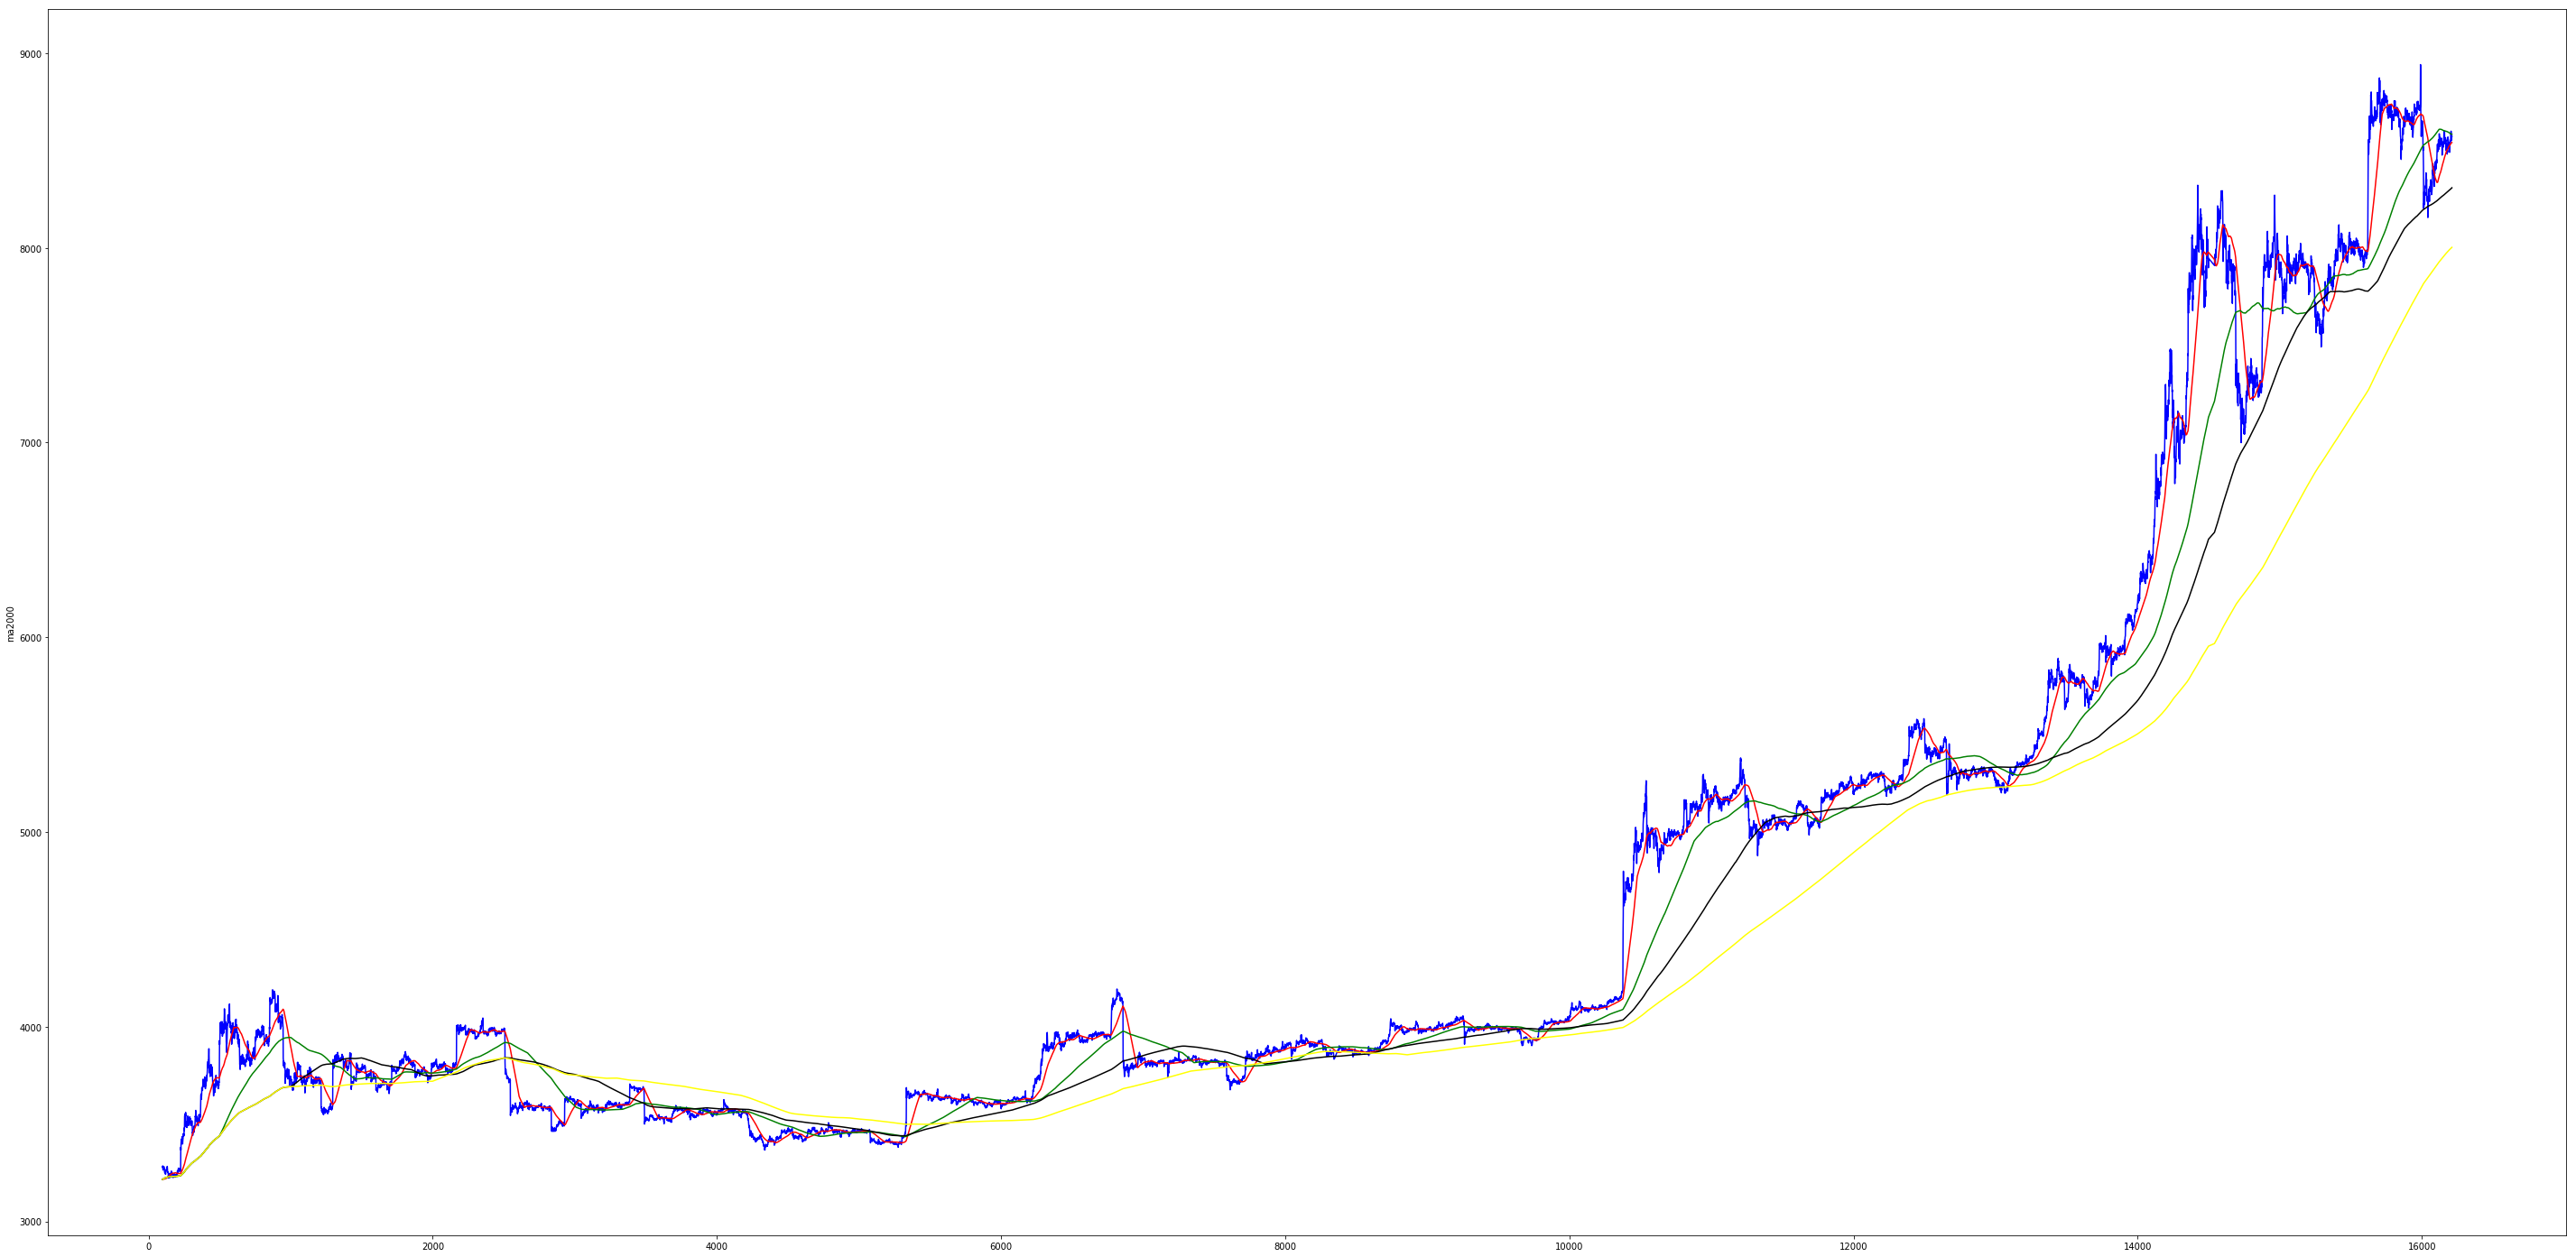

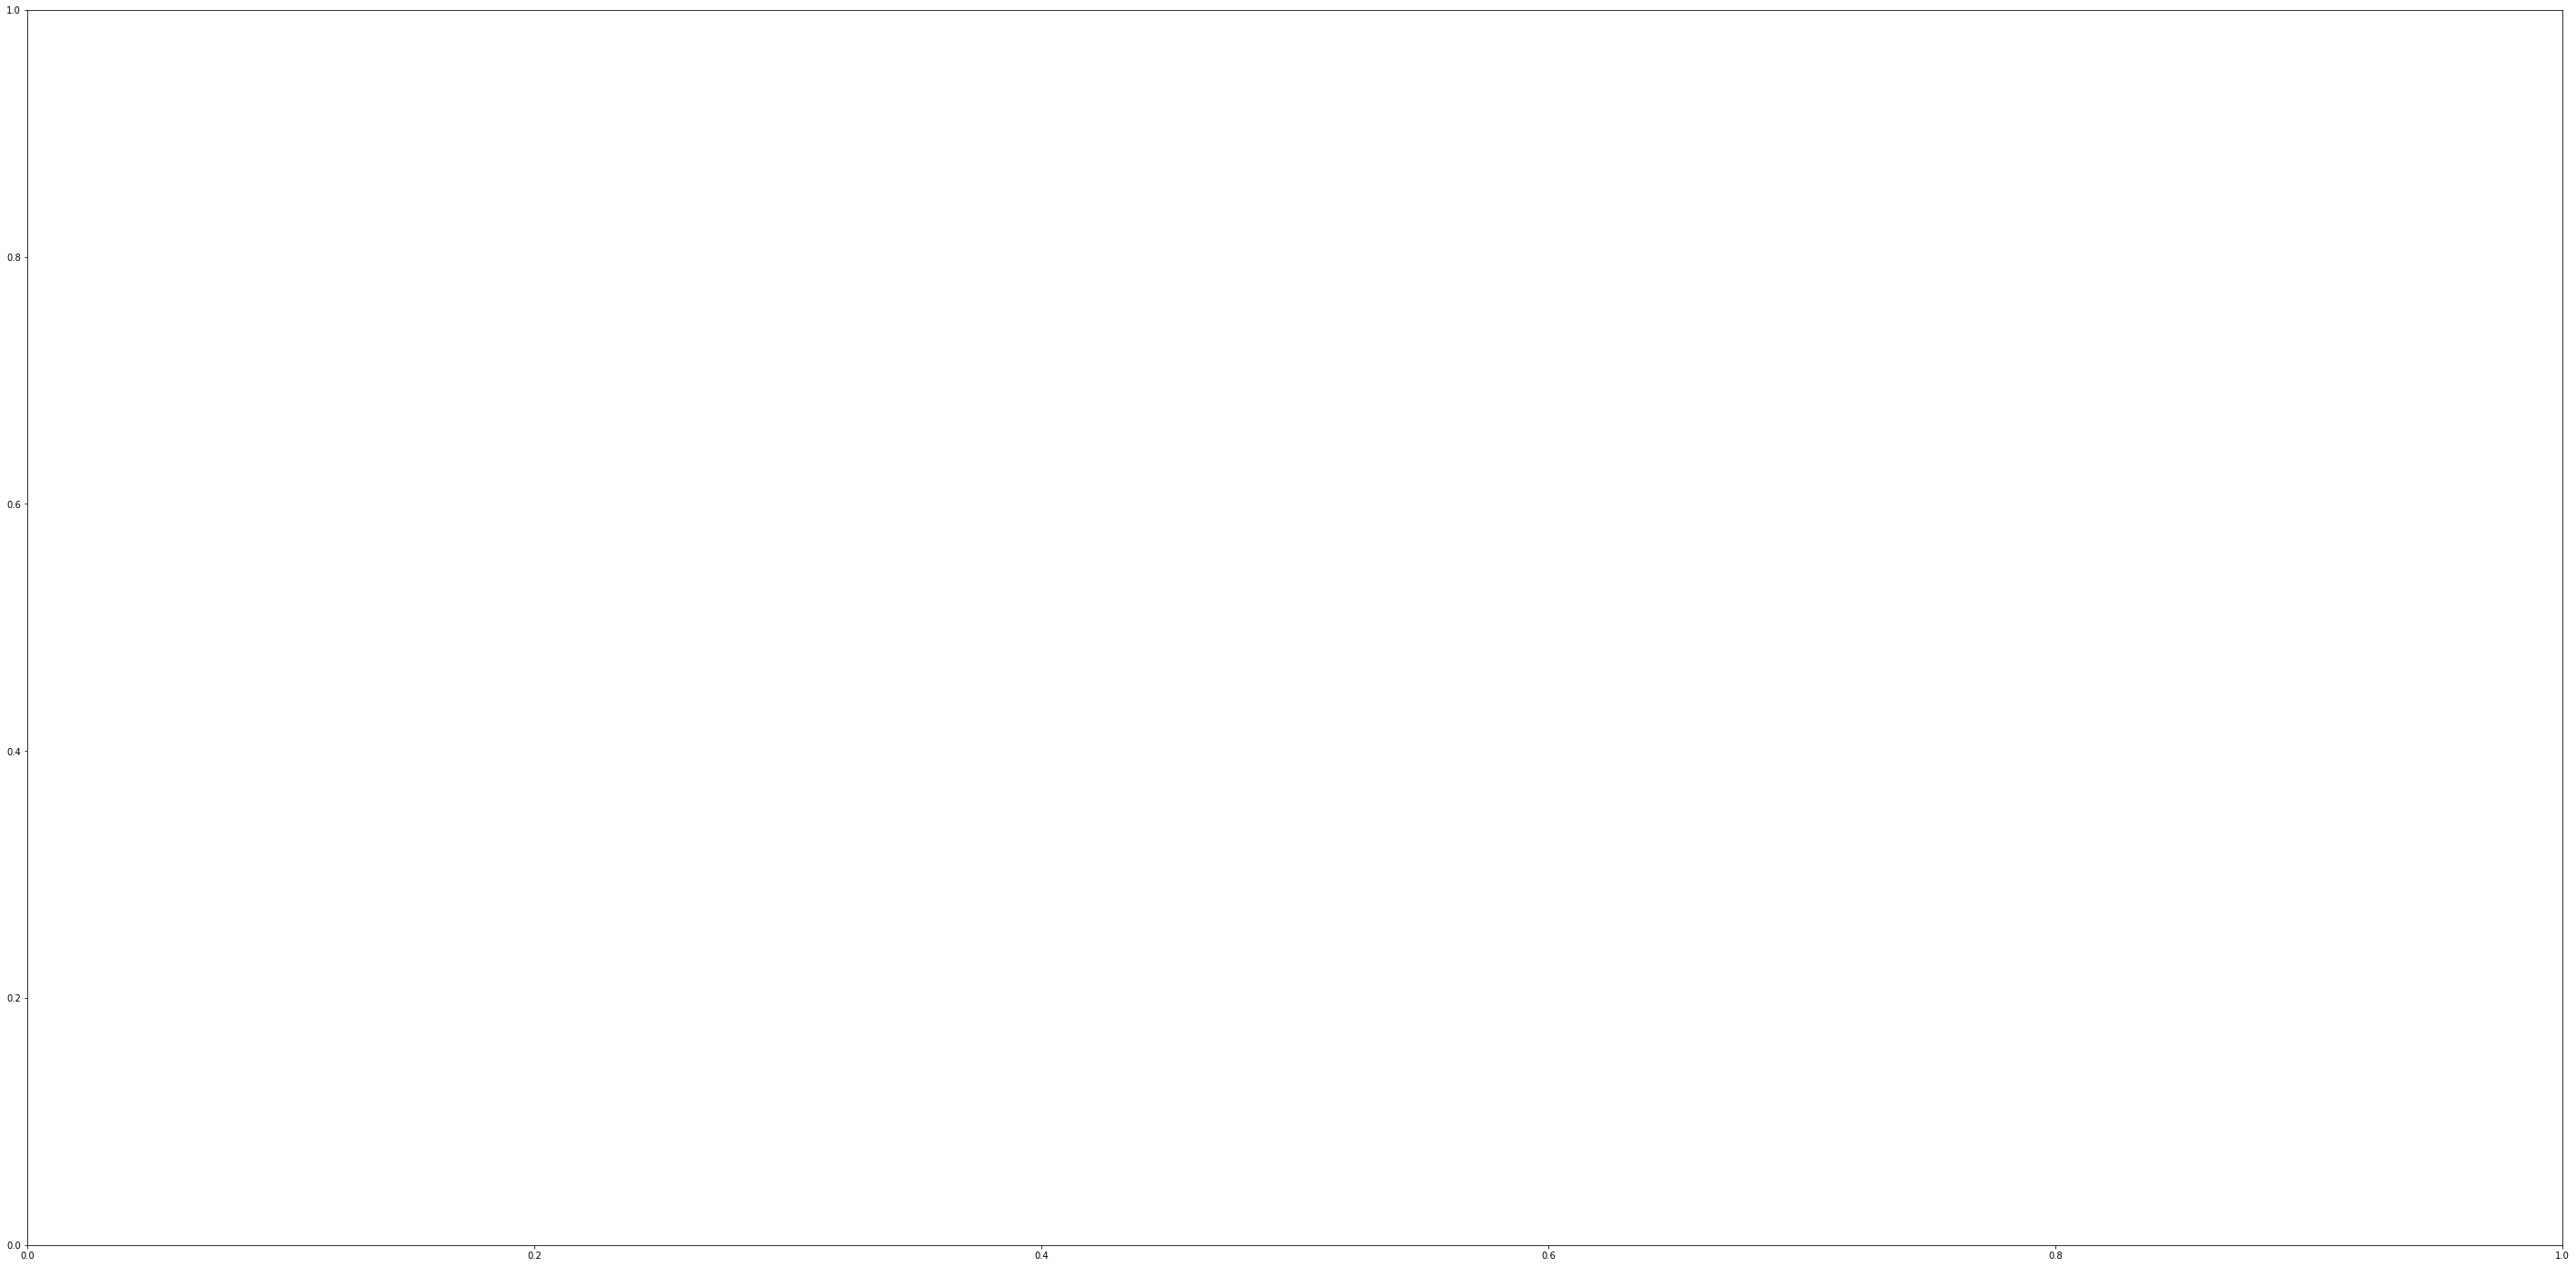

In [8]:
graph=data.loc[:,:] 
fig, ax = plt.subplots(figsize=(50,25))
sns.lineplot(graph.index, graph.close, color='blue')
sns.lineplot(graph.index, graph.ma100, color='red')
sns.lineplot(graph.index, graph.ma500, color='green')
sns.lineplot(graph.index, graph.ma1000, color='black')
sns.lineplot(graph.index, graph.ma2000, color='yellow')
fig, ax = plt.subplots(figsize=(50,25))
#sns.lineplot(graph.index, graph.is_l100, color='yellow')
#sns.scatterplot(graph.index, graph.profit, color='black')


In [144]:
data.profit.sum()

-734.4136000000021

In [147]:
data

,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,openTime,close,closeTime,high,low,numTrades,open,...,is_h100,ma20,ma100,ma500,cons_mvt,tot_mvt,ma500_trend,buyer_is_maker,profit,immo_time
99,99,99,99,2018-12-16 05:00:00,3278.04,2018-12-16 05:00:59.999,3293.64,3283.82,2393,3273.58,...,1,3239.1200,3215.6381,3215.638100,1.0,4.46,1,0.553220,NaN,NaN
100,100,100,100,2018-12-16 05:15:00,3285.22,2018-12-16 05:15:59.999,3286.37,3284.84,1334,3277.72,...,1,3242.5895,3216.0200,3216.327030,2.0,11.96,1,0.611154,NaN,NaN
101,101,101,101,2018-12-16 05:30:00,3273.98,2018-12-16 05:30:59.999,3285.25,3282.04,1367,3285.00,...,1,3245.5655,3216.2883,3216.892255,2.0,-22.04,1,0.443155,NaN,NaN
102,102,102,102,2018-12-16 05:45:00,3264.00,2018-12-16 05:45:59.999,3274.00,3270.00,1400,3273.25,...,0,3248.1795,3216.3661,3217.349612,3.0,-31.29,1,0.356123,NaN,NaN
103,103,103,103,2018-12-16 06:00:00,3269.96,2018-12-16 06:00:59.999,3271.61,3269.08,1152,3263.99,...,0,3250.9260,3216.5757,3217.855481,1.0,5.97,1,0.382805,NaN,NaN
104,104,104,104,2018-12-16 06:15:00,3266.11,2018-12-16 06:15:59.999,3270.66,3269.26,873,3269.53,...,0,3253.1250,3216.6582,3218.315048,2.0,-6.84,1,0.435503,NaN,NaN
105,105,105,105,2018-12-16 06:30:00,3270.94,2018-12-16 06:30:59.999,3271.53,3268.05,900,3265.67,...,0,3255.8890,3216.7345,3218.811509,1.0,5.27,1,0.479862,NaN,NaN
106,106,106,106,2018-12-16 06:45:00,3269.39,2018-12-16 06:45:59.999,3273.77,3271.26,834,3270.00,...,0,3258.6585,3216.8422,3219.284206,2.0,-1.22,1,0.597671,NaN,NaN
107,107,107,107,2018-12-16 07:00:00,3278.50,2018-12-16 07:00:59.999,3278.93,3276.00,1025,3270.33,...,1,3261.7080,3217.1076,3219.832500,1.0,8.17,1,0.549383,NaN,NaN
108,108,108,108,2018-12-16 07:15:00,3281.98,2018-12-16 07:15:59.999,3282.00,3279.03,1259,3276.61,...,1,3264.7635,3217.4816,3220.402661,2.0,13.54,1,0.637705,NaN,NaN
